INSA ROUEN <br>
MS ESD 2019-2010 <br>
Winnie VORIHILALA

# <center> TP Arbres CART et forêts aléatoires </center>

L'objectif de ce TP est d'apprendre à créer des arbres CART et des forêts aléatoires en utilisant 2 jeux de données : 
- spam : contient 4061 emails classés en spam et non-spams
- ozone : contient des données météorologiques et calendaires utilisés pour prédire la concentration maximale d'ozone associée à un jour de l'année 1976 dans la région de Los Angeles.

### Généralités

- Lien 1 (définition arbre de décision): https://fr.wikipedia.org/wiki/Arbre_de_décision <br>
- Lien 2 (construction d'un arbre de décision) : https://fr.wikipedia.org/wiki/Arbre_de_décision_(apprentissage) <br>
- Lien 3 (pour accéder aux slides de cours) : https://mycore.core-cloud.net/index.php/s/cygfbit4QzhRjiW#pdfviewer <br>
- Lien 4 (documentation complète en français): https://hal.archives-ouvertes.fr/hal-01387654v2/document <br>

# <font color='blue'>1. Les données </font>

## 1- Installation des librairies 

In [1]:
#Installation
install.packages("kernlab")
install.packages("mlbench")
install.packages("rpart")
install.packages("randomForest")
install.packages("rpart.plot")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [1]:
#Chargement
library(kernlab)
library(mlbench)
library(rpart)
library(randomForest)
library(rpart.plot)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


## 2 - Chargement du jeu de données et split en apprentissage/test

In [50]:
data(spam) #charge les données spam présents dans kernlab
dim(spam) #affiche les dimensions de spam
class(spam) #affiche le type de spam
head(spam) #affiche les 6 premières lignes et toutes les colonnes de spam

[1] 4601   58

[1] "data.frame"

make,address,all,num3d,our,over,remove,internet,order,mail,...,charSemicolon,charRoundbracket,charSquarebracket,charExclamation,charDollar,charHash,capitalAve,capitalLong,capitalTotal,type
0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0,0.778,0.000,0.000,3.756,61,278,spam
0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0,0.372,0.180,0.048,5.114,101,1028,spam
0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0,0.276,0.184,0.010,9.821,485,2259,spam
0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0,0.137,0.000,0.000,3.537,40,191,spam
0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0,0.135,0.000,0.000,3.537,40,191,spam
0.00,0.00,0.00,0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0,0.000,0.000,0.000,3.000,15,54,spam


In [51]:
#Descriptif du jeu de données 
?spam 

Le jeu de données spam, est dû à un ingénieur de HP, prénommé George, qui a analysé un échantillon de ses emails professionnels : <br>
— Les individus sont les 4601 emails en question dont 2788 sont des emails souhaitables et 1813 (soit 40%) des emails indésirables, c’est-à-dire des spams. <br>
— La variable type est donc binaire : spam ou non-spam. <br>
— les variables explicatives sont au nombre de p = 57 : 54 sont des proportions d’occurrences de mots ou de caractères, comme par exemple $,!, free, money, 2 sont liées aux longueurs des suites de lettres majuscules (la moyenne, la plus longue) et enfin la dernière est le nombre de lettres majuscules dans le mail. Ces variables sont classiques et définies grâce à des procédures usuelles en analyse textuelle, permettant de traiter statistiquement des individus caractérisés par des textes. <br>

Le but est double. 
- Premièrement, construire un “bon” filtre anti-spam : un nouveau mail arrive, il faut réussir à prédire si c’est un spam ou non. 
- Deuxièmement, on s’intéresse aussi à savoir quelles sont les variables sur lesquelles se base le plus le filtre anti-spam (ici des mots ou des caractères). <br>

Pour juger de la performance d’un filtre anti-spam, on découpe le jeu de données en deux : 2300 mails pour l’apprentissage, 2301 mails pour tester les prédictions. <br>

Nous avons donc un problème de classification à 2 classes (L = 2) avec un nombre d’individus (n = 2300 pour l’apprentissage, la construction des modèles) largement plus important que le nombre de variables (p = 57). <br>

De plus, nous disposons d’un échantillon test de grande taille (m = 2301) pour évaluer une estimation de l’erreur de prédiction.

In [52]:
#Vérification des types de chacune des variables
#lapply(spam,class) // décommenter

On constate que parmi les 58 variables composant le jeu de données spam, 57 sont de type numérique et seule la dernière variable "type" est de type factor. Le type factor est généralement utilisé pour représenter des variables catégorielles. 

In [53]:
#Création d'une table de contingence relative à la variable catégorielle type
set.seed(9146301)
ytable <- table(spam$type) #fonction table() crée une table de contingence
ytable


nonspam    spam 
   2788    1813 

Notre jeu de données spam contient bien 4601 mails dont 2788 appartenant à la classe non-spam et 1813 à la classe spam.

In [54]:
#Split des données en apprentissage et test
app <- c(sample(1:ytable[2], ytable[2]/2), sample((ytable[2] + 1):nrow(spam),ytable[1]/2)) #indices
spam.app <- spam[app, ]
spam.test <- spam[-app, ]
dim(spam.app)
dim(spam.test)

[1] 2300   58

[1] 2301   58

In [55]:
#Création d'une table de contigence relative à la variable catégorielle spam.app$type
apptable <- table(spam.app$type)
apptable


nonspam    spam 
   1394     906 

Notre jeu de données d'apprentissage spam.app contient 2300 mails dont 1394 appartenant à la classe non-spam et 906 à la classe spam.

In [56]:
#Création d'une table de contigence relative à la variable catégorielle spam.test$type
testtable <- table(spam.test$type)
testtable


nonspam    spam 
   1394     907 

Notre jeu de données de test spam.test contient 2301 mails dont 1394 appartenant à la classe non-spam et 907 à la classe spam.

In [57]:
# Récupération du nombre de lignes et colonnes de spam.app qui serviront plus bas
n <- nrow(spam.app)
p <- ncol(spam.app) - 1
paste(n)
paste(p)

[1] "2300"

[1] "57"

# <font color='blue'>2. Arbres CART </font>

Les arbres décisionnels font partie des méthodes d'apprentissage supervisé qui visent à prédire les valeurs prises par une variable en fonction d'un jeu de variables d'entrée (qu'on appelle également les descripteurs). Cette prédiction se fait à travers la construction d'un arbre dont chaque noeud correspond à une décision quant à la valeur de la variable à prédire. Cette décision est prise en fonction de la valeur d'un des descripteurs. La variable à prédire et les descripteurs, peuvent être quantitatifs ou catégoriels. <br>
<br>
Dans notre cas, la variable à prédire est "type" (variable catégorielle qui prend 2 valeurs : soit spam soit non-spam). Les prédicteurs sont au nombre de 57. Nous allons donc construire un arbre de classification, et son objectif est de prédire si un mail est un spam ou non.<br>

L'acronyme CART désigne une méthode statistique, introduite par Breiman et al. (1984) qui construit des prédicteurs par arbre aussi bien en régression qu’en classification. <br>

Le principe général de CART est de partitionner récursivement l’espace d’entrée X de façon binaire, puis de déterminer une sous-partition optimale pour la prédiction. Bâtir un arbre CART se fait en deux étapes. 
- une première phase est la construction d’un arbre maximal, qui permet de définir la famille de modèles à l’intérieur de laquelle on cherchera à sélectionner le meilleur
- une seconde phase, dite d’élagage, qui construit une suite de sous-arbres optimaux élagués de l’arbre maximal.

## 1 - Chargement de la librairie rpart

In [58]:
library(rpart)

## 2 - Calcul de l'arbre par défaut fourni par rpart

La fonction de construction d'un arbre s'appelle rpart, comme le package. On l'utilise en général avec l'interface des formules de R, comme ci-dessous :

In [59]:
t_def = rpart(type ~ .,data = spam.app)

La formule utilisée type~. indique qu'on souhaite prédire la variable type en fonction de toutes les autres. Le principe général est que la (ou les) variable(s) à prédire sont à gauche du symbole ~ alors que les variables prédictives sont à droite du symbole. Ici, le point . permet d'indiquer qu'on souhaite utiliser toutes les variables des données comme prédicteurs sauf les variables à prédire (ce qui évite d'avoir à écrire la liste des prédicteurs).

On a utilisé ici les paramètres par défaut de la fonction rpart, ce qui ne conduit pas toujours à la solution désirée. En effet, rpart ne construit en général pas l'arbre le plus complet possible, pour des raisons d'efficacité. Il est rare en pratique qu'un arbre très profond qui ne réalise aucune erreur de classement sur les données d'apprentissage soit le plus adapté. Il sur-apprend massivement, en général. Il n'est donc pas très utile de construire un tel arbre, puisqu'on devra en pratique l'élaguer.

Cependant, il arrive sur des données de petite taille que les paramètres par défaut de rpart soient trop conservateurs. Par exemple, rpart ne découpe pas une feuille contenant 20 observations. De même rpart demande une amélioration relative d'au moins 1 % de la qualité d'une partition pour effectuer un découpage. Pour changer ces valeurs, il suffit d'utiliser la commande rpart.control en précisant les éléments à modifier que nous verrons un peu plus bas.

In [60]:
#Affichage de l'arbre par défaut créé avec rpart 
t_def

n= 2300 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 2300 906 nonspam (0.60608696 0.39391304)  
   2) charDollar< 0.0295 1683 378 nonspam (0.77540107 0.22459893)  
     4) remove< 0.065 1527 238 nonspam (0.84413883 0.15586117)  
       8) charExclamation< 0.4765 1358 124 nonspam (0.90868925 0.09131075) *
       9) charExclamation>=0.4765 169  55 spam (0.32544379 0.67455621)  
        18) capitalLong< 10.5 66  21 nonspam (0.68181818 0.31818182) *
        19) capitalLong>=10.5 103  10 spam (0.09708738 0.90291262) *
     5) remove>=0.065 156  16 spam (0.10256410 0.89743590)  
      10) george>=0.14 10   0 nonspam (1.00000000 0.00000000) *
      11) george< 0.14 146   6 spam (0.04109589 0.95890411) *
   3) charDollar>=0.0295 617  89 spam (0.14424635 0.85575365)  
     6) hp>=0.385 55   6 nonspam (0.89090909 0.10909091) *
     7) hp< 0.385 562  40 spam (0.07117438 0.92882562)  
      14) edu>=0.185 16   2 nonspam (0.87500000 0.12500000) *
      15) edu< 0.1

Voici comment interptéter l'affichage ci-dessus :
- A la racine de l'arbre (branche 1) il y a 2300 emails dont seulement 906 qui sont classés "spam". C'est donc la classe "non-spam" qui l'emporte (à 60.6%).
- L'arbre présente un noeud qui se divise en 2 branches (branches 2 et 3). 
- La branche 2 correspond aux emails tels que charDollar< 0.0295 (fréquence d'apparition du mot charDollar dans le mail soit inférieur à 2.95%). Il y a 1683 emails dans cette branche dont seulement 378 qui sont classés "spam". C'est donc la classe "non-spam" qui l'emporte (à 77,5%)
- La branche 3 correspond au reste des emails (2300-1683=617 emails) tels que charDollar>=0.0295. Il y a 617 emails dans cette branche dont seulement 89 qui sont classés "spam". C'est donc la classe "non-spam" qui l'emporte à 85,6%.
- La branche 2 présente à son tour un noeud qui se divise en 2 branches (branche 4 et 5). 
- La branche 4 correspond aux emails tels que remove < 0.065. Il y a 1527 emails dans cette branche dont seulement 238 qui sont classés "spam". C'est donc la classe "non-spam" qui l'emporte (à 84,4%)
- La branche 5 correspond au reste des individus (1683-1527=156 emails) tels que remove>=0.065. Il y a 156 emails dans cette branche dont seulement 16 qui sont classés "spam". C'est donc la classe "non-spam" qui l'emporte à 89,7%.
Et ainsi de suite.
- 6,8,10,11,14,15,18,19 sont les feuilles de l'arbre.

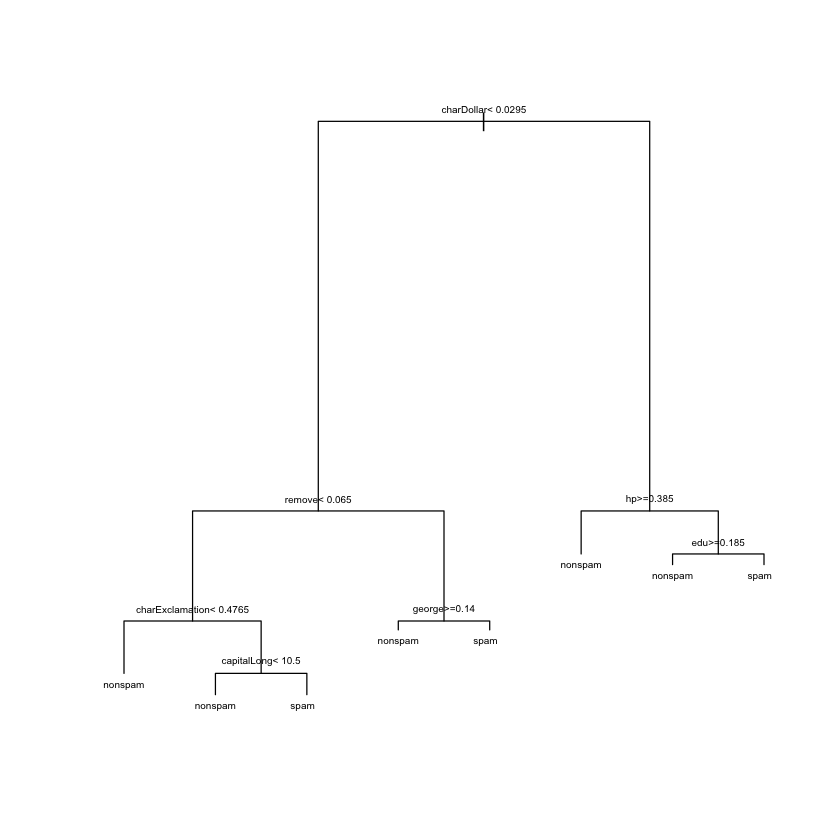

In [61]:
# Affichage graphique de l'arbre
plot(t_def)
text(t_def, cex = 0.5)

L'arbre de classification ci-dessus s'interprète de la manière suivante : 
- si la fréquence d'apparition du mot charDollar est supérieure à 0.0295, et si la fréquence d'apparition du mot hp est supérieure ou égale à 0.385 alors les mails sont classés comme "non-spam".
- si la fréquence d'apparition du mot charDollar est supérieure à 0.0295, et si la fréquence d'apparition du mot hp est inférieure ou égale à 0.385, et si la fréquence d'apparition du mot edu est inférieure ou égale à 0.185, alors les mails sont classés comme "spam".
- si la fréquence d'apparition du mot charDollar est supérieure à 0.0295, et si la fréquence d'apparition du mot hp est inférieure ou égale à 0.385, et si la fréquence d'apparition du mot edu est supérieure ou égale à 0.185, alors les mails sont classés comme "non-spam".
- si la fréquence d'apparition du mot charDollar est inférieure à 0.0295, et si la fréquence d'apparition du mot remove est supérieure à 0.065, et si la fréquence d'apparition du mot george est inférieure ou égale à 0.14, alors les mails sont classés comme "spam".
- si la fréquence d'apparition du mot charDollar est inférieure à 0.0295, et si la fréquence d'apparition du mot remove est supérieure à 0.065, et si la fréquence d'apparition du mot george est supérieure ou égale à 0.14, alors les mails sont classés comme "non-spam".
- si la fréquence d'apparition du mot charDollar est inférieure à 0.0295, et si la fréquence d'apparition du mot remove est inférieure à 0.065, et si la fréquence d'apparition du mot charExclamation est inférieure à 0.4765, alors les mails sont classés comme "non-spam".
- si la fréquence d'apparition du mot charDollar est inférieure à 0.0295, et si la fréquence d'apparition du mot remove est inférieure à 0.065, et si la fréquence d'apparition du mot charExclamation est supérieure à 0.4765, et si la fréquence d'apparition du mot capitalLong est inférieure à 10.5, alors les mails sont classés comme "non-spam".
- si la fréquence d'apparition du mot charDollar est inférieure à 0.0295, et si la fréquence d'apparition du mot remove est inférieure à 0.065, et si la fréquence d'apparition du mot charExclamation est supérieure à 0.4765, et si la fréquence d'apparition du mot capitalLong est supérieure à 10.5, alors les mails sont classés comme "spam". <br>

L'arbre de décision est créé de sorte que chaque noeud divise un ensemble de mails en deux sous-ensembles (correspondant aux 2 branches) les plus homogènes possibles en terme de variable à prédire.

In [62]:
#summary(t_def)

La commande summary donne des informations exhaustives sur l'arbre, notamment :
- le nombre d'observations n de spam
- le tableu de complexité (qui contient les valeurs du paramètre de complexité cp, le nombre de split nsplit, le taux d'erreur de resubstitution (xstand), le taux d'erreur à validation croisée (xerror), l'erreur standard (xstd).
- l'importance des variable 
- la découpe primaire et la découpe de susbstitution qui a lieu en chaque noeud. 

L'interprétation de l'arbre sous cette forme n'est cependant pas facile, d'où l'utilisation de l'affichage graphique qui facilite cela. 

# 3 - Construction d'un arbre de profondeur 1 (stump) et affichage graphique

In [63]:
tstump <- rpart(type ~ ., spam.app, control = rpart.control(maxdepth = 1))

In [64]:
tstump

n= 2300 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 2300 906 nonspam (0.6060870 0.3939130)  
  2) charDollar< 0.0295 1683 378 nonspam (0.7754011 0.2245989) *
  3) charDollar>=0.0295 617  89 spam (0.1442464 0.8557536) *

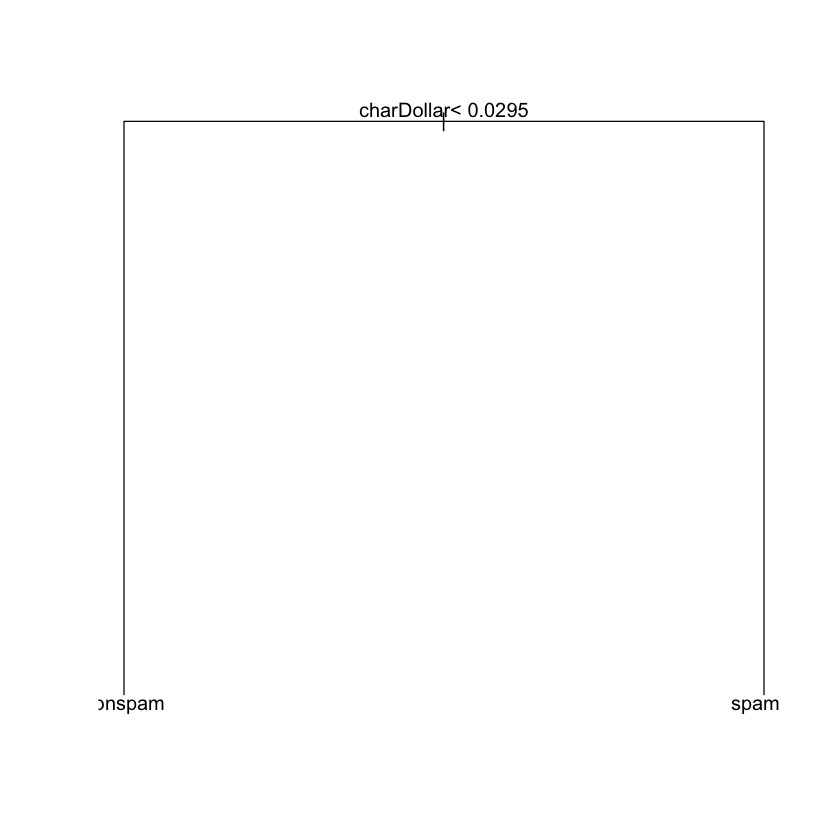

In [65]:
plot(tstump)
text(tstump)

L'arbre de classification ci-dessus s'interprète de la manière suivante : 
- si la fréquence d'apparition du mot charDollar est supérieure à 0.0295, alors les mails sont classés comme "spam".
- si la fréquence d'apparition du mot charDollar est inférieure à 0.0295, alors les mails sont classés comme "non-spam".

# 4 - Split compétitif et split de substitution

Autoriser toutes sortes de règles de décision aux nœuds intérieurs (également appelés divisions) n'a pas beaucoup de sens. L'idée même des arbres de décision est que : <br>
- les divisions à chaque nœud soient assez simples 
- les structures plus complexes soient capturées en enchaînant plusieurs décisions simples dans une structure arborescente.


Par conséquent, l'ensemble des divisions possibles est réduit en opposant plusieurs types de restrictions sur les divisions possibles:
- en limitant le nombre de variables utilisées par fractionnement (arbre de décision univarié vs multivarié),
- en limitant le nombre d'enfants par nœud (arbre de décision binaire vs n-aire),
- en n'autorisant que certains types spéciaux de divisions (par exemple, divisions complètes, divisions d'intervalle, etc.). <br>

La méthode CART construit des arbres binaires, que ce soit en classification ou en régression.

Le rôle de la division de substitution est d’obtenir une autre découpe proche de la découpe optimale (primary split) mais dans le sens de la règle d’acheminement. CART à travers les variables de substitutions, propose un traitement des valeurs manquantes NA. En effet, dans le cas d’une valeur manquante, il est peu optimal d’utiliser la meilleure variable concurrente qui ne respecte pas la règle d’acheminement de la variable en question (aiguillage vers le fils gauche ou droite du noeud). CART propose des découpes de substitution (surrogate) qui minimisent le nombre de désaccords avec la règle d’acheminement de la coupure optimale du noeud. 
<br>

Observons la découpe compétitive et la découpe de substitution ci-dessous : 

In [66]:
summary(tstump)

Call:
rpart(formula = type ~ ., data = spam.app, control = rpart.control(maxdepth = 1))
  n= 2300 

         CP nsplit rel error    xerror       xstd
1 0.4845475      0 1.0000000 1.0000000 0.02586446
2 0.0100000      1 0.5154525 0.5264901 0.02146152

Variable importance
 charDollar      num000       money capitalLong    internet      credit 
         43          16          15           9           9           8 

Node number 1: 2300 observations,    complexity param=0.4845475
  predicted class=nonspam  expected loss=0.393913  P(node) =1
    class counts:  1394   906
   probabilities: 0.606 0.394 
  left son=2 (1683 obs) right son=3 (617 obs)
  Primary splits:
      charDollar      < 0.0295 to the left,  improve=359.7022, (0 missing)
      charExclamation < 0.0825 to the left,  improve=327.4305, (0 missing)
      remove          < 0.01   to the left,  improve=299.7582, (0 missing)
      free            < 0.095  to the left,  improve=276.1917, (0 missing)
      your            < 0.415  

<strong> Découpes compétitives : </strong>
On peut disposer en chaque nœud de l’arbre de la suite ordonnée par réduction décroissante de l’hétérogénéité de toutes les découpes (une par variable explicative). C’est ce que l’on appelle les découpes compétitives ou concurrentes (competing splits) et elles sont, en tout nœud, nécessairement calculées lors de la construction de l’arbre maximal. La possibilité du développement manuel de l’arbre maximal peut être précieuse et s’opère en choisissant en chacun des nœuds dans la liste ordonnée des splits, soit la découpe optimale, soit une découpe légèrement moins bonne mais portant sur des variables moins incertaines, plus faciles, moins chères à mesurer ou encore plus interprétables. <br>

<strong> Valeurs manquantes : </strong>
L’une des difficultés concrètes pour le calcul d’une prédiction est la présence de valeurs manquantes. CART en offre un traitement efficace et très élégant. En effet, tout d’abord remarquons que lorsque des variables sont manquantes pour un x donné, cela ne pose un problème que si l’on passe par un nœud dont la coupure est basée sur l’une de ces va- riables. Ensuite, en un nœud ou la variable sur laquelle porte le split est manquante, on peut penser utiliser l’une des autres variables, par exemple la seconde découpe compétitive. Mais cette idée n’est pas optimale, puisque la règle d’acheminement dans les fils droit et gauche respectivement peut être très éloignée de la règle d’acheminement induite par la découpe optimale. D’où l’idée de calculer en chaque nœud la liste des découpes de substi- tution (surrogate splits) définies par la découpe minimisant le nombre de désaccords avec la règle d’acheminement induite par la coupure optimale. On dispose ainsi d’une méthode de traitement des valeurs manquantes en prédiction locale et performante, qui ne passe pas par des méthodes d’imputation globales et souvent trop grossières.
<font color='red'> Notons que si CART permet de bien gérer les valeurs manquantes en prédiction, les forêts aléatoires, qui sont des ensembles d’arbres non élagués, perdent essentiellement cette propriété</font>. En effet, tout d’abord, pour un arbre non élagué donné, le chemin de la racine à une feuille est en général beaucoup plus long et, de plus, potentiellement de nombreux arbres sont touchés par une variable manquante particulière. Des solutions existent néan- moins dans ce cadre avec les forêts aléatoires floues comme par exemple dans Valdiviezo and Van Aelst (2015) <br>

<strong> Interprétabilité : </strong>
L’interprétabilité est un des aspects qui font le succès des arbres CART. On peut, en effet, très facilement répondre à la question du pourquoi, pour un x donné, on prévoit telle valeur de y en fournissant la suite des réponses aux questions constituées par les découpes successives rencontrés pour parcourir, pour le x en question, l’unique chemin de la racine à la feuille associée. Notons que les forêts aléatoires perdent cette propriété d’interprétabilité puisqu’il n’existe pas d’arbre associé à une forêt, même si l’on peut signaler des tentatives pour définir un arbre approchant en un certain sens une forêt, comme par exemple Hara and Hayashi (2016).
Mais de manière plus globale, au delà de l’interprétation d’une prédiction particulière, on peut, une fois l’arbre CART construit, considérer que les variables qui interviennent dans les découpes des nœuds de l’arbre (en particulier les nœuds les plus proches de la racine) sont les variables les plus utiles pour le problème considéré. En effet, plus une découpe est proche de la racine plus la décroissance de l’hétérogénéité est importante. C’est une façon heuristique et pratique d’avoir une information sur l’importance des variables. En réalité, cette première intuition donne des résultats biaisés et un indice d’importance des variables plus élaboré est fourni par les arbres CART. Il est basé à nouveau sur la notion de découpes de substitution. Suivant Breiman et al. (1984), on peut définir l’importance d’une variable en évaluant, en chaque nœud, la réduction d’hétérogénéité engendrée par l’usage du split de substitution portant sur cette variable puis en les sommant sur tous les nœuds.

# 5 - Construction d'un arbre maximal et affichage graphique

A chaque pas du partitionnement, on découpe une partie de l’espace en deux sous- parties. On associe alors naturellement un arbre binaire à la partition construite. Les nœuds de l’arbre sont associés aux éléments de la partition. Par exemple, la racine de l’arbre est associé à l’espace d’entrée tout entier. Ses deux nœuds fils sont associés aux deux sous-parties obtenues par la première découpe du partitionnement, et ainsi de suite. <br>
=> Détails mathématiques sur la règle de découpe : cf page 12-13 https://hal.archives-ouvertes.fr/hal-01387654v2/document. 

La commande rpart.control permet de construire un arbre en spécifiant les paramètres qu'on souhaite lui attribuer, notamment :
- minsplit : le nombre minimal d'observations qui doit exister dans un nœud pour qu'une tentative de division soit tentée.
- cp : paramètre de complexité. Aucune division qui ne diminue pas le manque global d'ajustement par un facteur de cp n'est tentée. Le rôle principal de ce paramètre est de gagner du temps de calcul en élaguant les divisions qui ne valent pas la peine. Essentiellement, l'utilisateur informe le programme que tout fractionnement qui n'améliore pas l'ajustement par cp sera probablement élagué par validation croisée, et que par conséquent le programme n'a pas besoin de le poursuivre.
Des détails sur l'utilisation des autres paramètres sont disponibles dans la documentation R de rpart.control.

In [67]:
tmax <- rpart(type ~ ., data = spam.app, control = rpart.control(minsplit = 1,cp = 0))

Ici, on construit un arbre en continuant les découpages dans les feuilles qui contiennent au moins 1 observation (paramètre minsplit) et sans contrainte sur la qualité du découpage (paramètre cp mis à 0). L'arbre construit de cette façon est assez volumineux et contient plusieurs feuilles.

In [68]:
#tmax

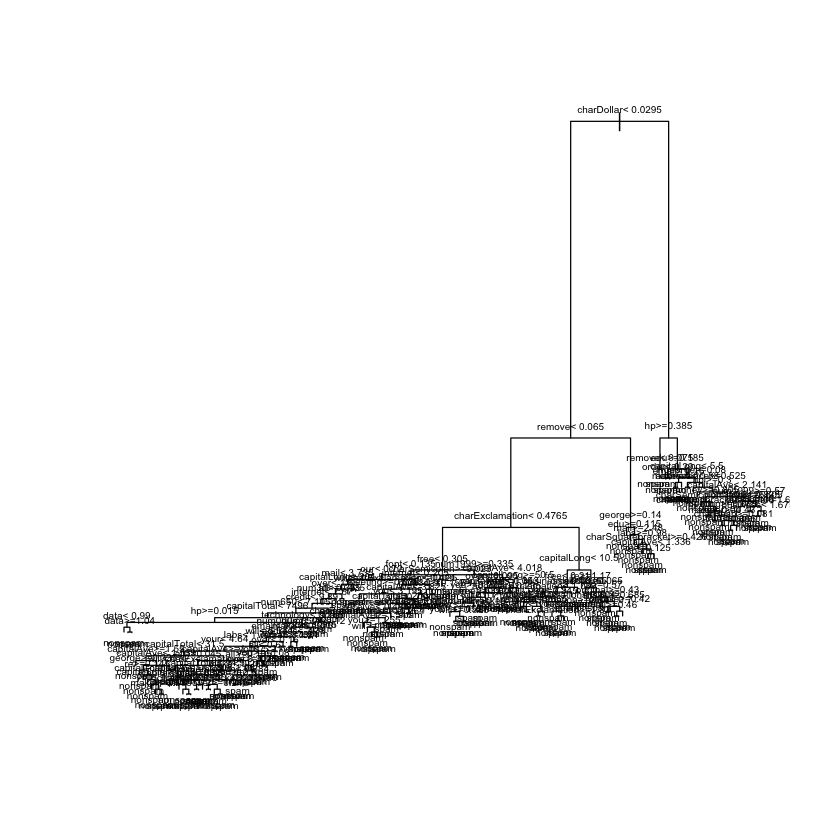

In [69]:
#affichage graphique
plot(tmax)
text(tmax, cex = 0.5)

Pour choisir le bon niveau de simplification, ou encore le bon nombre de feuilles, on procède par validation croisée. La fonction rpart réalise par défaut une estimation des performances de l'arbre par validation croisée à 10 blocs pour chaque niveau de simplification pertinent. Le nombre de blocs se règle au moment de la construction de l'arbre grâce au paramètre xval de rpart.control. <br>
On peut afficher les résultats de cette opération grâce à la fonction printcp, comme ci-dessus, ou la fonction plotcp plus bas pour un affichage graphique. <br>

# 6- Erreur de validation croisée de la suite de Breiman 

La deuxième étape de l’algorithme CART, s’appelle l’élagage et consiste à chercher le meilleur sous-arbre élagué de l’arbre maximal (meilleur au sens de l’erreur de généralisation). L’idée est que l’arbre maximal possède une très grande variance et un biais faible. A contrario, un arbre constitué uniquement de la racine (qui engendre alors un prédicteur constant) a une très petite variance mais un biais élevé. <font color='red'>L’élagage est une procédure de sélection de modèles, où les modèles sont les sous-arbres élagués de l’arbre maximal</font>, soit tous les sous-arbres binaires de $T_{max}$ ayant la même racine que $T_{max}$. Cette procédure minimise un critère pénalisé où la pénalité est proportionnelle au nombre de feuilles de l’arbre.

Tous les sous-arbres binaires de $T_{max}$ contenant la racine sont des modèles admissibles. Entre $T_{max}$, le modèle de complexité maximale, qui conduit au surajustement aux données de l’échantillon d’apprentissage et l’arbre restreint à la racine qui est fortement biaisé, il s’agit de trouver l’arbre optimal parmi les admissibles. En nombre fini, il suffirait donc au moins en principe, de construire la suite de tous les meilleurs arbres à $k$ feuilles pour $1 ≤􏰏 k 􏰏 ≤ |T_{max}| $, où $|T|$ désigne le nombre de feuilles de l’arbre $T$, et de les comparer par exemple sur un échantillon test. Mais le nombre de modèles admissibles est exponentiel d’où une complexité algorithmique explosive. Fort heureusement, une énumération implicite et efficace suffit pour atteindre un résultat optimal. Le moyen consiste simplement dans l’algorithme d’élagage qui assure l’extraction d’une suite de sous-arbres emboîtés (c’est-à-dire élagués les uns des autres) $T_1, . . . , T_K$ tous élagués de $T_{max}$, où $T_k$ minimise un critère des moindres carrés pénalisé en régression. Cette suite est obtenue de manière itérative en coupant des branches à chaque étape, ce qui ramène la complexité à un niveau très raisonnable. <br>
=> Détails mathématiques sur l'algorithme d"élagage de CART : cf page 14-15 https://hal.archives-ouvertes.fr/hal-01387654v2/document. 

La figure ci-dessous représente la <font color='red'>suite optimale des sous-arbres élagués Tmax obtenue par la construction de l’arbre maximal et l’application de l’algorithme d’élagage</font>.

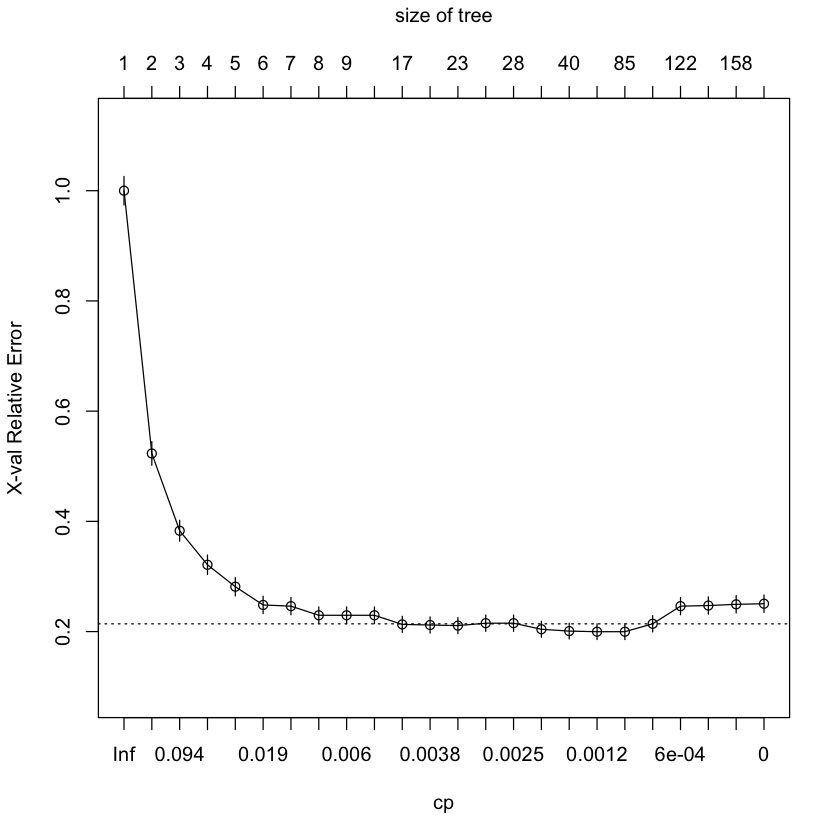

In [73]:
plotcp(tmax)

Chaque point représente ainsi un arbre, avec l’estimation de l’écart-type de l’erreur de validation croisée sous forme de segment vertical. L’arbre minimisant ce critère est parfois encore un peu trop complexe (85 feuilles ici).  et en relaxant un peu la condition de minimisation de l’erreur de prédiction par la règle du “1 écart-type” (1 s.e. rule de Breiman qui tient compte de l’incertitude de l’estimation de l’erreur des arbres de la suite), on obtient l’arbre ci-dessous (arbre tprune).

On cherche à minimiser l’erreur pour définir le niveau d’élagage. Comme attendu, les performances s'améliorent dans un premier temps quand on augmente le nombre de feuilles puis se dégradent en raison du sur-apprentissage. On choisit en général le cp optimal qui minimise l'erreur estimée.


# 7- Recherche du meilleur d’entre eux au sens d’une estimation de l’erreur de prédiction par validation croisée

Pour obtenir l'arbre simplifié ou optimal, on utilise la fonction prune, comme dans le code suivant. <br>
On utilise ici le cp affiché sur la courbe, ce qui n'est pas très pratique. Pour automatiser le processus, on peut s'appuyer sur l'attribut cptable des objets arbres. Cette matrice contient toutes les informations utilisées pour produire le graphique ci-dessus. En pratique, on peut retrouver l'arbre optimal en faisant :

In [74]:
tprune <- prune(tmax, cp = tmax$cptable[which.min(tmax$cptable[, 4]), 1]) #cp = cp qui mimimise xerror
#tprune

Notons que la valeur de cp obtenue de cette façon n'est pas la même que celle affichée sur la figure : les valeurs contenues dans la matrice cptable sont celles qui produisent des changements dans le nombre de feuilles de l'arbre. Pour des raisons de stabilité, on préfère parfois utiliser les moyennes géométriques de deux nombres qui se suivent.

In [75]:
head(tmax$cptable)

CP,nsplit,rel error,xerror,xstd
0.48454746,0,1.0000000,1.0000000,0.02586446
0.13686534,1,0.5154525,0.5231788,0.02141152
0.06512141,2,0.3785872,0.3830022,0.01894627
0.04746137,3,0.3134658,0.3211921,0.01759723
0.02649007,4,0.2660044,0.2814570,0.01661976
0.01324503,5,0.2395143,0.2483444,0.01572564


In [76]:
tmax$cptable[which.min(tmax$cptable[, 4]), 1] #cp optimal

[1] 0.001103753

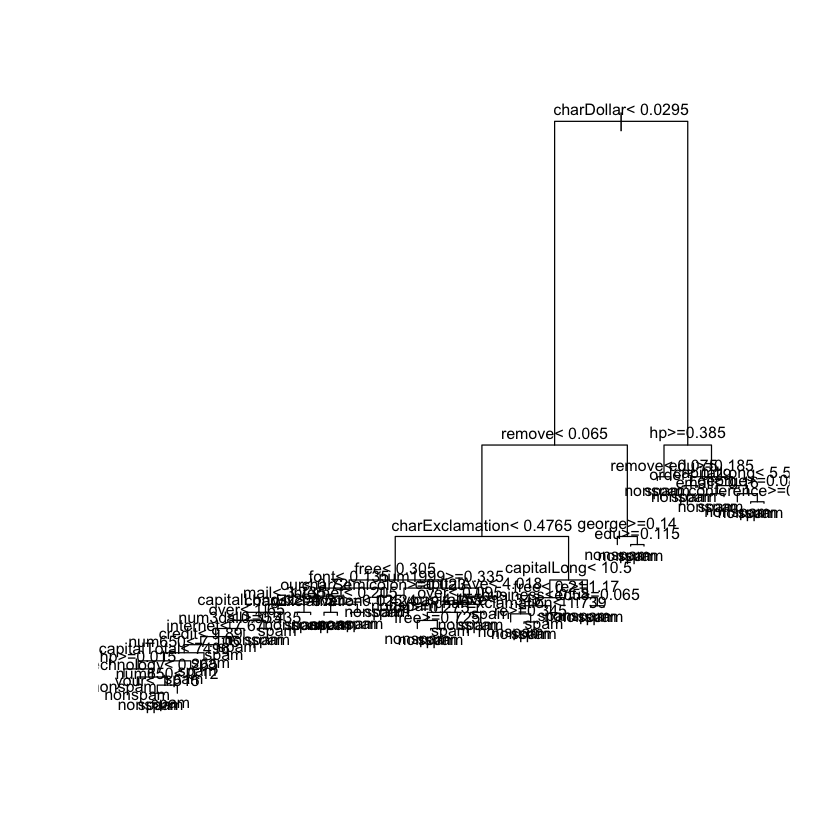

In [77]:
plot(tprune)
text(tprune, cex = 0.8)

On constate que l'arbre optimal est moins dense que l'arbre maximal.

# Représentation graphique

Le package rpart propose des fonctions d'affichage relativement limitées. On préfère donc s'appuyer sur rpart.plot, en particulier sur sa fonction prp. La figure ci-dessous est obtenue par le simple appel suivant :

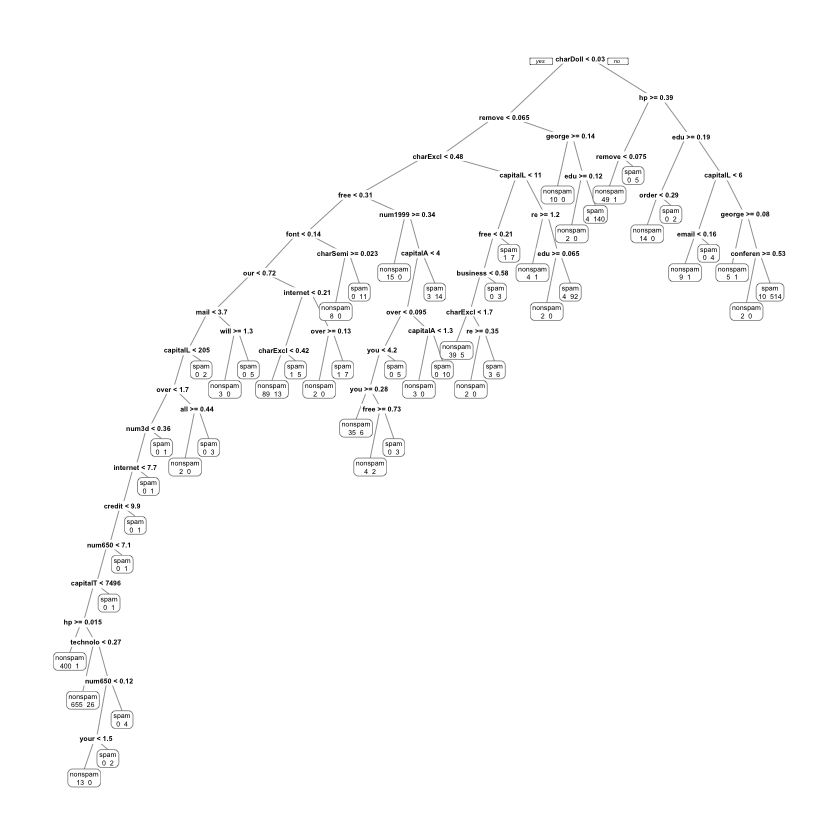

In [78]:
prp(tprune,extra=1)

Arbre optimal : chaque nœud représente une question, la réponse non étant toujours dans la branche droite de l'arbre. Chaque feuille est étiquetée par la décision associée (ici spam ou non-spam) et par l'effectif classe par classe des mails affectés à la feuille. Par exemple, la feuille la plus à droite classe les mails en spam, avec 514 mails appartenant à cette classe et 10 appartenant à la classe "spam".

# 8 - Comparaison de l’arbre par défaut de rpart avec celui obtenu par minimisation de l’erreur de prédiction. Idem avec celui minimisant l’erreur de prédiction par la règle du 1 SE

In [79]:
thres1SE <- sum(tmax$cptable[ which.min(tmax$cptable[, 4]), 4:5]) #seuil d'élagage
cp1SE <- tmax$cptable[ min(which(tmax$cptable[, 4] <= thres1SE)),1] #on prend le cp qui minimise xerror et qui est <= au seuil
tprune_1se <- prune(tmax, cp = cp1SE)
print(thres1SE)
print(cp1SE)

[1] 0.2140325
[1] 0.004415011


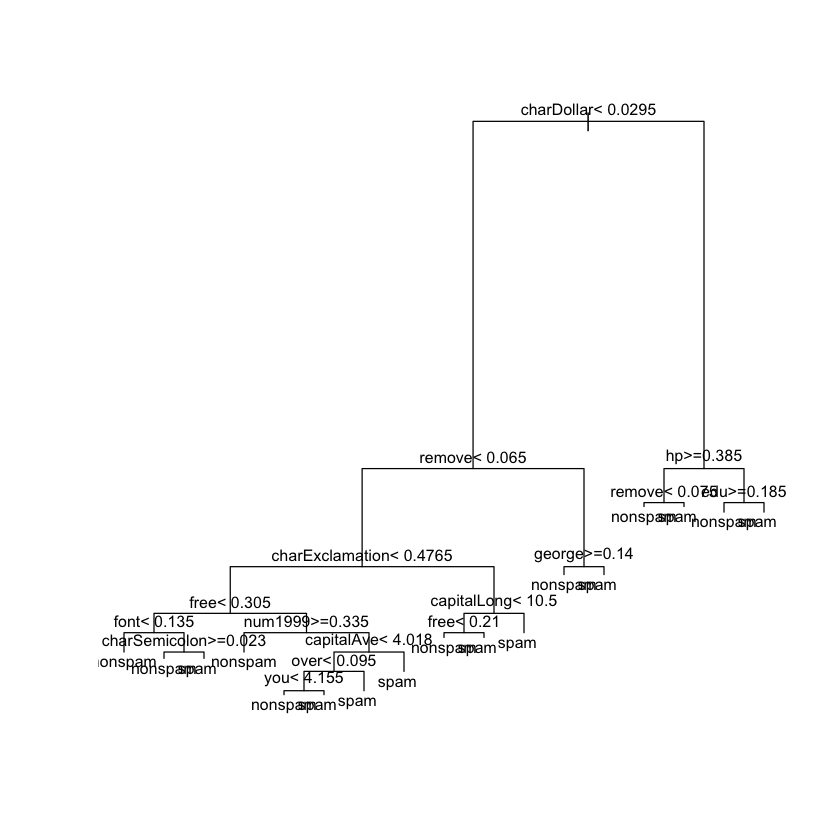

In [80]:
plot(tprune_1se)
text(tprune_1se, cex = 0.8)

In [81]:
identical(t_def, tprune_1sd)
identical(tprune, tprune_1sd)

[1] FALSE

[1] FALSE

In [82]:
identical(t_def, tmax)
identical(tmax, tprune)
identical(tstump, tprune)
identical(tstump, tmax)
identical(tprune, tprune_1sd)

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

Le nouvel arbre tprune_1sd est différent de l'arbre obtenu par défaut, mais également différent de l'arbre maximal.

# 9 - Comparaison des erreurs obtenus en apprentissage et en test

In [36]:
#arbre stump, profondeur=1, 2 feuilles
predstump <- predict(tstump, spam.test, type="class")
errstump <- round(sum(predstump!=spam.test$type)/nrow(spam.test), 3)
appstump <- round(sum(predict(tstump, spam.app, type="class")!=spam.app$type)/nrow(spam.app), 3)

#arbre maximal
predmax <- predict(tmax, spam.test, type="class")
errmax <- round(sum(predmax!=spam.test$type)/nrow(spam.test), 3)
appmax <- round(sum(predict(tmax, spam.app, type="class")!=spam.app$type)/nrow(spam.app), 3)

#arbre 1 SE
pred_1se<- predict(tprune_1se, spam.test, type="class")
err_1se <- round(sum(pred_1se!=spam.test$type)/nrow(spam.test), 3)
app_1se <- round(sum(predict(tprune_1se, spam.app, type="class")!=spam.app$type)/nrow(spam.app), 3)


#arbre otpimal
predprune <- predict(tprune, spam.test, type="class")
errprune <- round(sum(predprune!=spam.test$type)/nrow(spam.test), 3)
appprune <- round(sum(predict(tprune, spam.app, type="class")!=spam.app$type)/nrow(spam.app), 3)

In [75]:
cat("L\'erreur de prédiction de l\'arbre de profondeur 1 sur le jeu de données de test est:",errstump,"\n")
cat("L\'erreur de prédiction de l\'arbre de profondeur 1 sur le jeu de données d'apprentissage est:",appstump,"\n")
print("-------")

cat("L\'erreur de prédiction de l\'arbre de profondeur maximale sur le jeu de données de test est:",errmax,"\n")
cat("L\'erreur de prédiction de l\'arbre de profondeur maximale sur le jeu de données d'apprentissage est:",appmax,"\n")
print("-------")

cat("L\'erreur de prédiction de l\'arbre 1SE sur le jeu de données de test est:",err_1se,"\n")
cat("L\'erreur de prédiction de l\'arbre 1SE sur le jeu de données d'apprentissage est:",app_1se,"\n")
print("-------")

print("-------")
cat("L\'erreur de prédiction de l\'arbre optimal sur le jeu de données de test est:",errprune,"\n")
cat("L\'erreur de prédiction de de l\'arbre optimal sur le jeu de données d'apprentissage est:",appprune,"\n")
print("-------")

L'erreur de prédiction de l'arbre de profondeur 1 sur le jeu de données de test est: 0.21 
L'erreur de prédiction de l'arbre de profondeur 1 sur le jeu de données d'apprentissage est: 0.203 
[1] "-------"
L'erreur de prédiction de l'arbre de profondeur maximale sur le jeu de données de test est: 0.09 
L'erreur de prédiction de l'arbre de profondeur maximale sur le jeu de données d'apprentissage est: 0.002 
[1] "-------"
L'erreur de prédiction de l'arbre 1SE sur le jeu de données de test est: 0.094 
L'erreur de prédiction de l'arbre 1SE sur le jeu de données d'apprentissage est: 0.065 
[1] "-------"
[1] "-------"
L'erreur de prédiction de l'arbre optimal sur le jeu de données de test est: 0.089 
L'erreur de prédiction de de l'arbre optimal sur le jeu de données d'apprentissage est: 0.037 
[1] "-------"


Les erreurs obtenues sur les jeux de données de test sont bien supérieures à celles obtenues en aprentissage. Le taux d'erreur de généralisation le plus faible est obtenu sans surprise avec l'arbre optimal. (8.9%).


# <font color='blue'>3. Arbres CART sur données Ozone </font>

## 1 - Chargement des données et split en apprentisage et test

In [2]:
data(Ozone)
dim(Ozone) #affiche les dimensions de Ozone
class(Ozone) #affiche le type de Ozone
head(Ozone) 

[1] 366  13

[1] "data.frame"

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
1,1,4,3,5480,8,20,NA,NA,5000,-15,30.56,200
1,2,5,3,5660,6,NA,38,NA,NA,-14,NA,300
1,3,6,3,5710,4,28,40,NA,2693,-25,47.66,250
1,4,7,5,5700,3,37,45,NA,590,-24,55.04,100
1,5,1,5,5760,3,51,54,45.32,1450,25,57.02,60
1,6,2,6,5720,4,69,35,49.64,1568,15,53.78,60


In [39]:
#Descriptif du jeu de données 
#?Ozone 

Ozone est un dataframe contenant 366 lignes et 13 variables contenant des informations relatives à la pollution de l'air.<br>
La variable à prédire est V4. <br>
Le problème est de prévoir la lecture quotidienne maximale moyenne d'une heure de l'ozone (V4). <br>
Voici i-dessous comment se lisent les colonnes de Ozone.

1	Month: 1 = January, ..., 12 = December <br>
2	Day of month <br>
3	Day of week: 1 = Monday, ..., 7 = Sunday <br>
4	Daily maximum one-hour-average ozone reading <br>
5	500 millibar pressure height (m) measured at Vandenberg AFB <br>
6	Wind speed (mph) at Los Angeles International Airport (LAX) <br>
7	Humidity (%) at LAX <br>
8	Temperature (degrees F) measured at Sandburg, CA <br>
9	Temperature (degrees F) measured at El Monte, CA <br>
10	Inversion base height (feet) at LAX <br>
11	Pressure gradient (mm Hg) from LAX to Daggett, CA <br>
12	Inversion base temperature (degrees F) at LAX <br>
13	Visibility (miles) measured at LAX <br>

In [40]:
lapply(Ozone,class)

$V1
[1] "factor"

$V2
[1] "factor"

$V3
[1] "factor"

$V4
[1] "numeric"

$V5
[1] "numeric"

$V6
[1] "numeric"

$V7
[1] "numeric"

$V8
[1] "numeric"

$V9
[1] "numeric"

$V10
[1] "numeric"

$V11
[1] "numeric"

$V12
[1] "numeric"

$V13
[1] "numeric"

La variable V4 à prédire est bien de type numérique. Nous avons 3 variables catégorielles V1, V2 et V3 qu'il faudra convertir en numérique.

In [3]:
#conversion des factor en numeric
Ozone$V1 <- as.numeric(Ozone$V1)
Ozone$V2 <- as.numeric(Ozone$V2)
Ozone$V2 <- as.numeric(Ozone$V2)

In [4]:
summary(Ozone)

       V1               V2        V3           V4              V5      
 Min.   : 1.000   Min.   : 1.00   1:52   Min.   : 1.00   Min.   :5320  
 1st Qu.: 4.000   1st Qu.: 8.00   2:52   1st Qu.: 5.00   1st Qu.:5700  
 Median : 7.000   Median :16.00   3:52   Median : 9.00   Median :5770  
 Mean   : 6.514   Mean   :15.76   4:53   Mean   :11.53   Mean   :5753  
 3rd Qu.: 9.750   3rd Qu.:23.00   5:53   3rd Qu.:16.00   3rd Qu.:5830  
 Max.   :12.000   Max.   :31.00   6:52   Max.   :38.00   Max.   :5950  
                                  7:52   NA's   :5       NA's   :12    
       V6               V7              V8              V9       
 Min.   : 0.000   Min.   :19.00   Min.   :25.00   Min.   :27.68  
 1st Qu.: 3.000   1st Qu.:49.00   1st Qu.:51.00   1st Qu.:49.73  
 Median : 5.000   Median :65.00   Median :62.00   Median :57.02  
 Mean   : 4.869   Mean   :58.48   Mean   :61.91   Mean   :56.85  
 3rd Qu.: 6.000   3rd Qu.:73.00   3rd Qu.:72.00   3rd Qu.:66.11  
 Max.   :11.000   Max.   :93

On constate la présence de plusieurs valeurs NA. Il faut les enlever afin de ne pas faussser les calculs. 

In [5]:
#suppression des valeurs NA
Ozone <- na.omit(Ozone)                            

In [6]:
summary(Ozone)

       V1               V2       V3           V4              V5      
 Min.   : 1.000   Min.   : 1.0   1:37   Min.   : 1.00   Min.   :5320  
 1st Qu.: 3.000   1st Qu.: 9.0   2:45   1st Qu.: 5.00   1st Qu.:5690  
 Median : 6.000   Median :15.0   3:43   Median : 9.00   Median :5760  
 Mean   : 6.522   Mean   :15.7   4:36   Mean   :11.37   Mean   :5746  
 3rd Qu.:10.000   3rd Qu.:23.0   5:42   3rd Qu.:16.00   3rd Qu.:5830  
 Max.   :12.000   Max.   :31.0   6: 0   Max.   :38.00   Max.   :5950  
                                 7: 0                                 
       V6               V7              V8              V9       
 Min.   : 0.000   Min.   :19.00   Min.   :25.00   Min.   :27.68  
 1st Qu.: 3.000   1st Qu.:46.00   1st Qu.:51.50   1st Qu.:49.64  
 Median : 5.000   Median :64.00   Median :61.00   Median :56.48  
 Mean   : 4.867   Mean   :57.61   Mean   :61.11   Mean   :56.54  
 3rd Qu.: 6.000   3rd Qu.:73.00   3rd Qu.:71.00   3rd Qu.:66.20  
 Max.   :11.000   Max.   :93.00   Ma

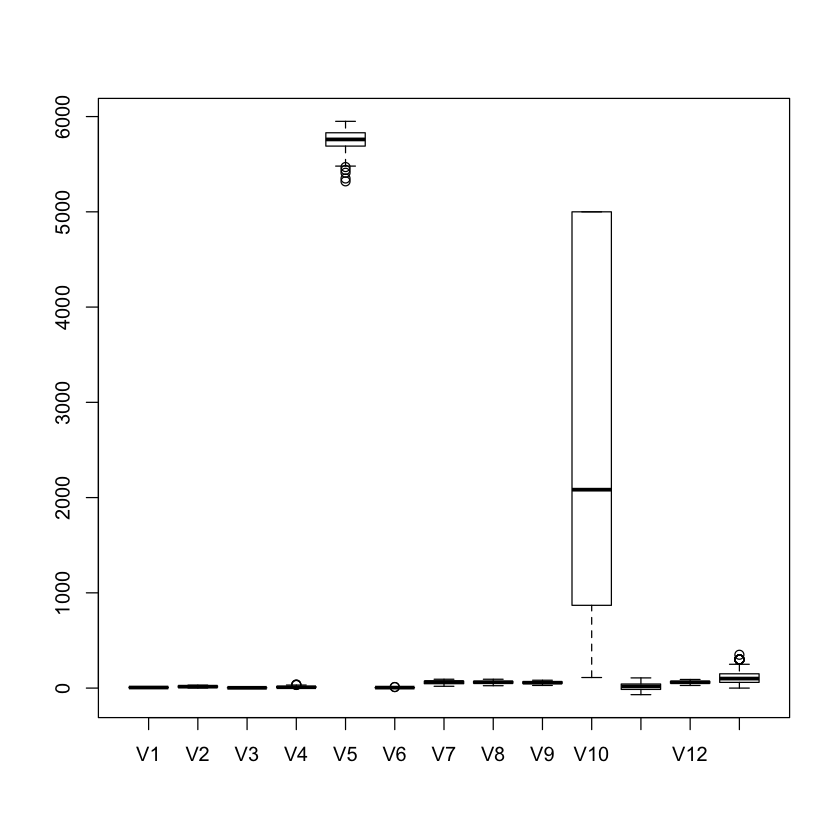

In [45]:
boxplot(Ozone)

On constate que nos données sont du même ordre de grandeur sauf V10. Toutefois, randomForest gère cela très bien. Mise à l'échelle pas nécessaire.

In [7]:
summary(Ozone$V4)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    5.00    9.00   11.37   16.00   38.00 

In [8]:
#Split des données en test et en apprentissage

set.seed(111)
app <- sample(1:nrow(Ozone), nrow(Ozone)*1/5) #80% apprentissage et 20% test
Ozone_app <- Ozone[app,]
Ozone_test <- Ozone[-app,]

In [9]:
#Vérification des dimensions de app et test

dim(Ozone)
dim(Ozone_app)
dim(Ozone_test)

[1] 203  13

[1] 40 13

[1] 163  13

## 2 - CART

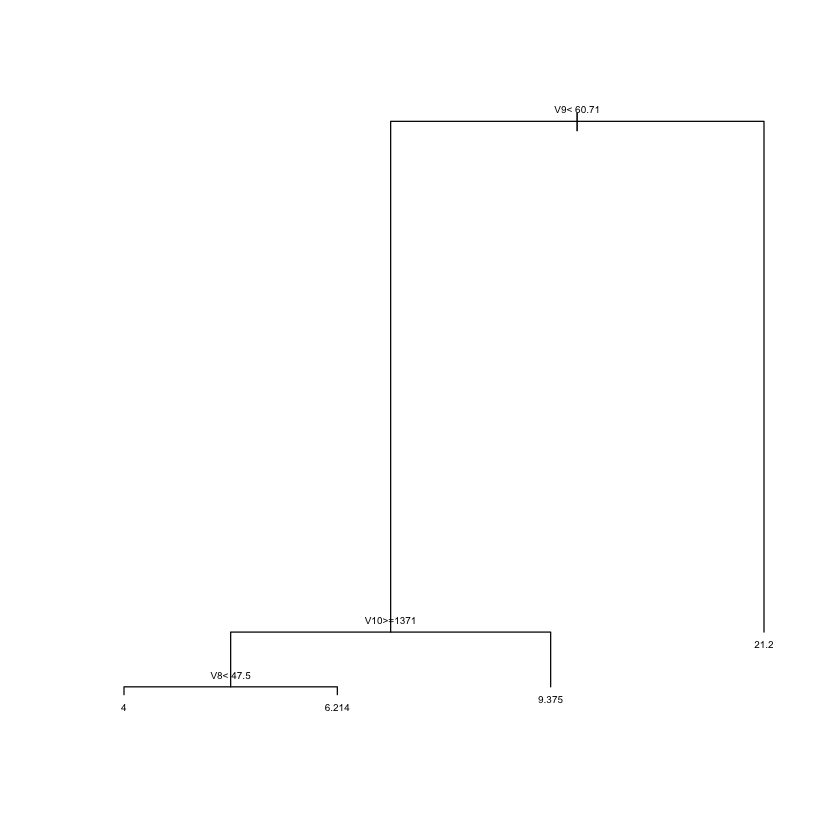

In [10]:
#Création de l'arbre par défaut

o_def=rpart(V4 ~ .,data = Ozone_app)
plot(o_def)
text(o_def, cex = 0.5)

Un arbre de régression se lit de haut en bas (de la racine aux feuilles).
La valeur indiquée en bas de chaque feuille indique la moyenne du sous-échantillon obtenu en suivant la lecture de l’arbre.

In [11]:
o_def

n= 40 

node), split, n, deviance, yval
      * denotes terminal node

1) root 40 2139.10000 10.150000  
  2) V9< 60.71 30  275.46670  6.466667  
    4) V10>=1371 22  113.31820  5.409091  
      8) V8< 47.5 8   28.00000  4.000000 *
      9) V8>=47.5 14   60.35714  6.214286 *
    5) V10< 1371 8   69.87500  9.375000 *
  3) V9>=60.71 10  235.60000 21.200000 *

In [12]:
#summary(o_def)

In [13]:
#Création de l'arbre stump à 2 feuilles et de profondeur 1

ostump <- rpart(V4 ~ ., Ozone_app, control = rpart.control(maxdepth = 1))

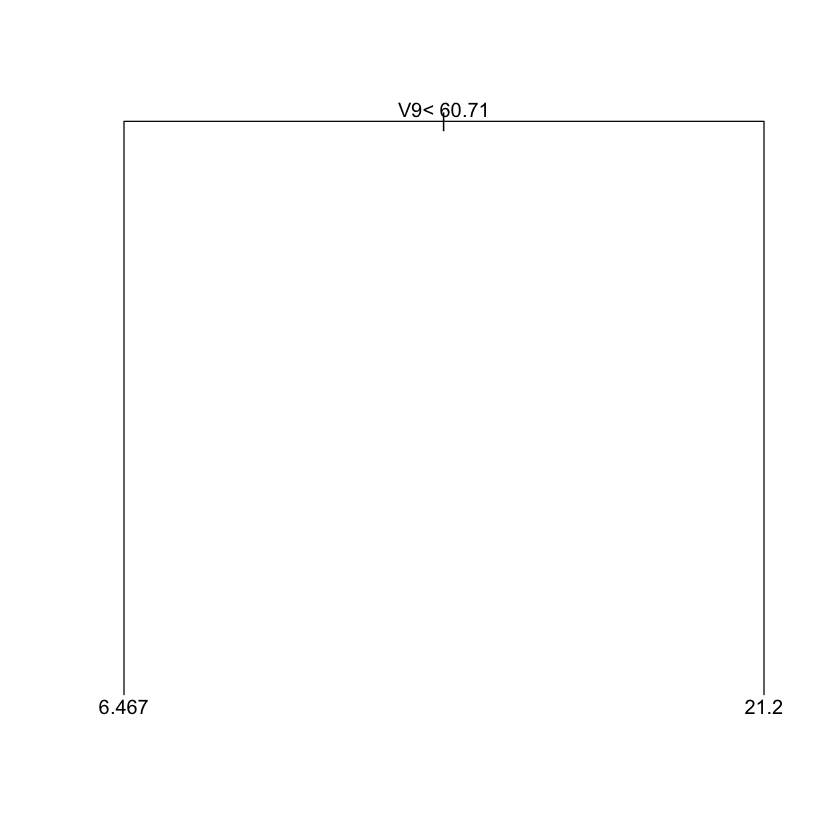

In [14]:
plot(ostump)
text(ostump)

In [15]:
summary(ostump)

Call:
rpart(formula = V4 ~ ., data = Ozone_app, control = rpart.control(maxdepth = 1))
  n= 40 

         CP nsplit rel error    xerror      xstd
1 0.7610833      0 1.0000000 1.0572521 0.2529369
2 0.0100000      1 0.2389167 0.5821541 0.1513605

Variable importance
 V9  V8 V12  V5 V10  V7 
 30  27  18  15   6   3 

Node number 1: 40 observations,    complexity param=0.7610833
  mean=10.15, MSE=53.4775 
  left son=2 (30 obs) right son=3 (10 obs)
  Primary splits:
      V9  < 60.71  to the left,  improve=0.7610833, (0 missing)
      V8  < 68     to the left,  improve=0.6522572, (0 missing)
      V12 < 63.59  to the left,  improve=0.5367522, (0 missing)
      V10 < 1933.5 to the right, improve=0.4607246, (0 missing)
      V5  < 5785   to the left,  improve=0.3790651, (0 missing)
  Surrogate splits:
      V8  < 68     to the left,  agree=0.975, adj=0.9, (0 split)
      V12 < 70.52  to the left,  agree=0.900, adj=0.6, (0 split)
      V5  < 5820   to the left,  agree=0.875, adj=0.5, (0 split)

In [17]:
# Création de l'arbre maximale

omax <- rpart(V4 ~ ., data = Ozone_app, control = rpart.control(cp = 0))

In [18]:
omax

n= 40 

node), split, n, deviance, yval
      * denotes terminal node

1) root 40 2139.10000 10.150000  
  2) V9< 60.71 30  275.46670  6.466667  
    4) V10>=1371 22  113.31820  5.409091  
      8) V8< 47.5 8   28.00000  4.000000 *
      9) V8>=47.5 14   60.35714  6.214286 *
    5) V10< 1371 8   69.87500  9.375000 *
  3) V9>=60.71 10  235.60000 21.200000 *

In [19]:
#summary(omax)

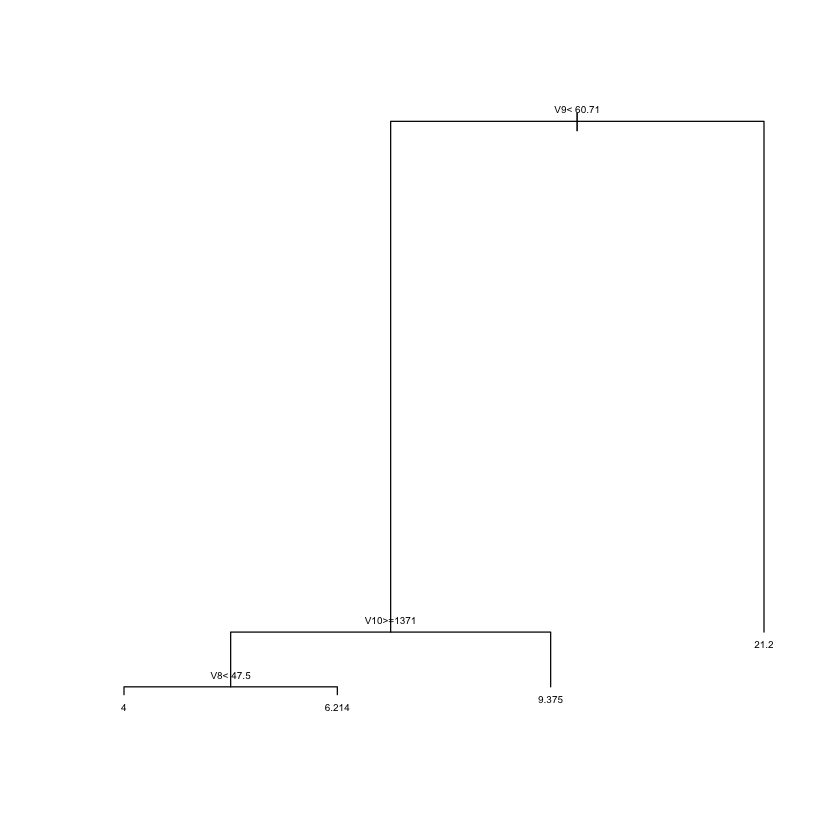

In [20]:
plot(omax)
text(omax, cex = 0.5)

In [22]:
omax$cptable

CP,nsplit,rel error,xerror,xstd
0.76108332,0,1.0000000,1.0278091,0.24937735
0.04313659,1,0.2389167,0.4493460,0.12613034
0.01166894,2,0.1957801,0.4064833,0.08870173
0.00000000,3,0.1841111,0.4039890,0.08874120


In [27]:
printcp(omax)


Regression tree:
rpart(formula = V4 ~ ., data = Ozone_app, control = rpart.control(cp = 0))

Variables actually used in tree construction:
[1] V10 V8  V9 

Root node error: 2139.1/40 = 53.477

n= 40 

        CP nsplit rel error  xerror     xstd
1 0.761083      0   1.00000 1.02781 0.249377
2 0.043137      1   0.23892 0.44935 0.126130
3 0.011669      2   0.19578 0.40648 0.088702
4 0.000000      3   0.18411 0.40399 0.088741


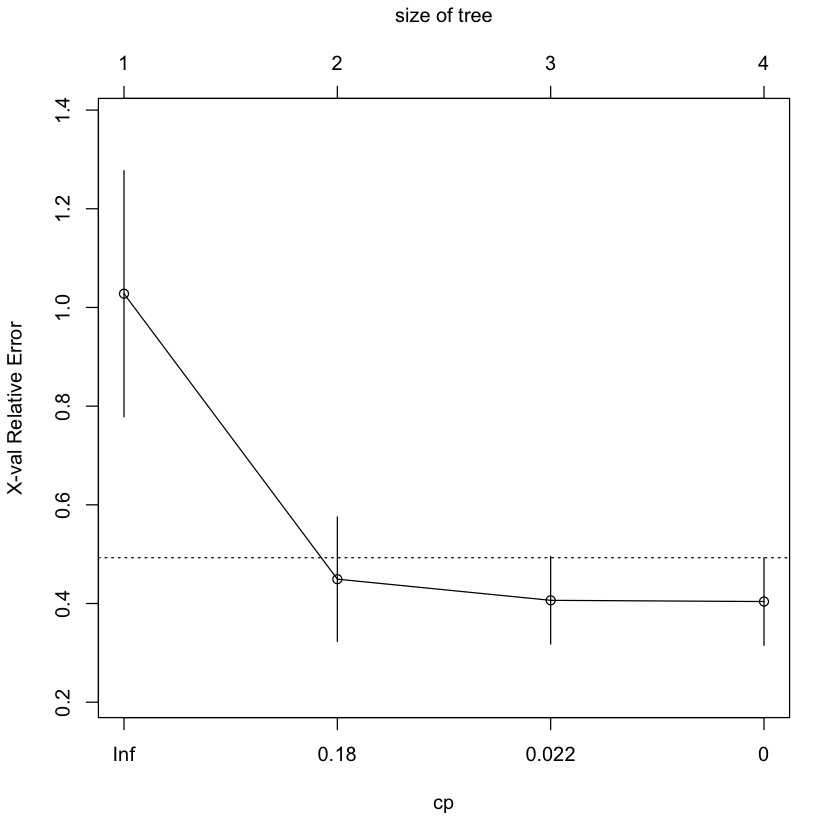

In [21]:
plotcp(omax)

In [31]:
min(omax$cptable[, 4])

[1] 0.403989

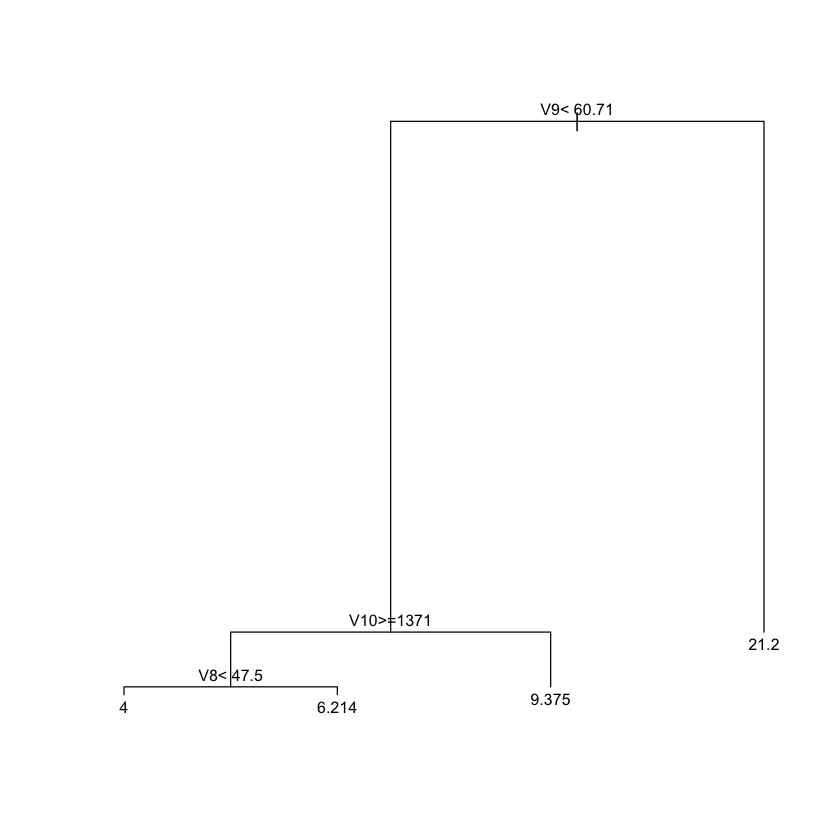

In [32]:
#Création de l'arbre optimal

oprune <- prune(omax, cp = omax$cptable[which.min(omax$cptable[, 4]), 1])
plot(oprune)
text(oprune, cex = 0.8)

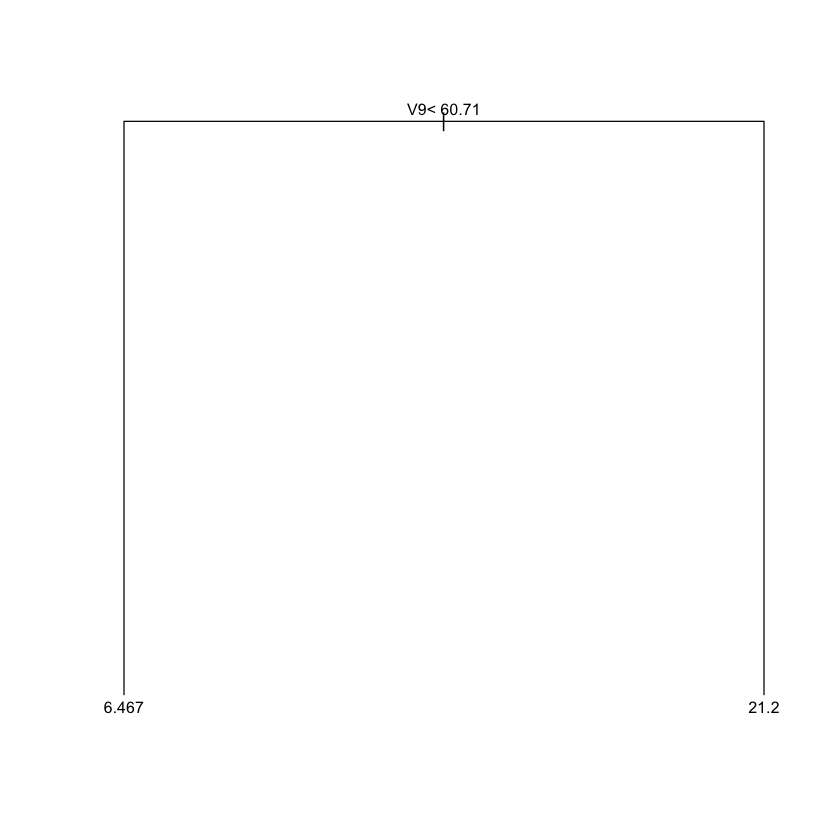

In [33]:
#Création de l'arbre 1SE

othres1SE <- sum(omax$cptable[ which.min(omax$cptable[, 4]), 4:5])
ocp1SE <- omax$cptable[ min(which(omax$cptable[, 4] <= othres1SE)), 1]
oprune_1se <- prune(omax, cp = ocp1SE)
plot(oprune_1se)
text(oprune_1se, cex = 0.8)

In [42]:
identical(o_def, omax)
identical(omax, oprune)
identical(o_def, oprune)
identical(o_def, oprune_1se)
#identical(o_def, oprune)

[1] FALSE

[1] TRUE

[1] FALSE

[1] FALSE

L'arbre optimal est identique à l'arbre maximal.

In [76]:
predstump_o <- predict(ostump, Ozone_test)
errstump_o <- round(sum((predstump_o-Ozone_test$V4)^2)/nrow(Ozone_test), 4)
predstump_o_a <- predict(ostump, Ozone_app)
appstump_o <- round(sum((predstump_o_a-Ozone_app$V4)^2)/nrow(Ozone_app), 4)

predmax_o <- predict(omax, Ozone_test)
errmax_o <- round(sum((predmax_o-Ozone_test$V4)^2)/nrow(Ozone_test), 4)
predmax_o_a <- predict(omax, Ozone_app)
appmax_o <- round(sum((predmax_o_a-Ozone_app$V4)^2)/nrow(Ozone_app), 4)

pred1SE_o <- predict(oprune_1se, Ozone_test)
err1SE_o <- round(sum((pred1SE_o-Ozone_test$V4)^2)/nrow(Ozone_test), 4)
pred1SE_o_a <- predict(oprune_1se, Ozone_app)
app1SE_o <- round(sum((pred1SE_o_a-Ozone_app$V4)^2)/nrow(Ozone_app), 4)

predprune_o <- predict(oprune, Ozone_test)
errprune_o <- round(sum((predprune_o-Ozone_test$V4)^2)/nrow(Ozone_test), 4)
predprune_o_a <- predict(oprune, Ozone_app)
appprune_o <- round(sum((predprune_o_a-Ozone_app$V4)^2)/nrow(Ozone_app), 4)

# MSE

In [77]:
cat("La MSE de l\'arbre de profondeur 1 sur le jeu de données de test est:",errstump_o,"\n")
cat("La MSE de l\'arbre de profondeur 1 sur le jeu de données d'apprentissage est:",appstump_o,"\n")
print("-------")

cat("La MSE de l\'arbre de profondeur maximale sur le jeu de données de test est:",errmax_o,"\n")
cat("La MSE de l\'arbre de profondeur maximale sur le jeu de données d'apprentissage est:",appmax_o,"\n")
print("-------")

cat("La MSE de l\'arbre 1SE sur le jeu de données de test est:",err1SE_o,"\n")
cat("La MSE de l\'arbre 1SE sur le jeu de données d'apprentissage est:",app1SE_o,"\n")
print("-------")

cat("La MSE de l\'arbre de profondeur optimale sur le jeu de données de test est:",errprune_o,"\n")
cat("La MSE de l\'arbre de profondeur optimale sur le jeu de données d'apprentissage est:",appprune_o,"\n")
print("-------")

La MSE de l'arbre de profondeur 1 sur le jeu de données de test est: 39.6948 
La MSE de l'arbre de profondeur 1 sur le jeu de données d'apprentissage est: 12.7767 
[1] "-------"
La MSE de l'arbre de profondeur maximale sur le jeu de données de test est: 37.7987 
La MSE de l'arbre de profondeur maximale sur le jeu de données d'apprentissage est: 9.8458 
[1] "-------"
La MSE de l'arbre 1SE sur le jeu de données de test est: 39.6948 
La MSE de l'arbre 1SE sur le jeu de données d'apprentissage est: 12.7767 
[1] "-------"
La MSE de l'arbre de profondeur optimale sur le jeu de données de test est: 37.7987 
La MSE de l'arbre de profondeur optimale sur le jeu de données d'apprentissage est: 9.8458 
[1] "-------"


# RMSE

In [78]:
rmse_err1SE_o <- sqrt(err1SE_o)
rmse_app1SE_o <- sqrt(app1SE_o)

rmse_errstump_o <- sqrt(errstump_o)
rmse_appstump_o <- sqrt(appstump_o)

rmse_errmax_o <- sqrt(errmax_o)
rmse_appmax_o <- sqrt(appmax_o)

rmse_errprune_o <- sqrt(errprune_o)
rmse_appprune_o <- sqrt(appprune_o)

In [79]:
cat("La RMSE de l\'arbre 1SE sur le jeu de données de test est:",rmse_err1SE_o,"\n")
cat("La RMSE de l\'arbre 1SE sur le jeu de données d'apprentissage est:",rmse_app1SE_o,"\n")
print("-------")
cat("La RMSE de l\'arbre de profondeur 1 sur le jeu de données de test est:",rmse_errstump_o,"\n")
cat("La RMSE de l\'arbre de profondeur 1 sur le jeu de données d'apprentissage est:",rmse_appstump_o,"\n")
print("-------")
cat("La RMSE de l\'arbre de profondeur maximale sur le jeu de données de test est:",rmse_errmax_o,"\n")
cat("La RMSE de l\'arbre de profondeur maximale sur le jeu de données d'apprentissage est:",rmse_appmax_o,"\n")
print("-------")
cat("La RMSE de l\'arbre de profondeur optimale sur le jeu de données de test est:",rmse_errprune_o,"\n")
cat("La RMSE de l\'arbre de profondeur optimale sur le jeu de données d'apprentissage est:",rmse_appprune_o,"\n")
print("-------")

La RMSE de l'arbre 1SE sur le jeu de données de test est: 6.300381 
La RMSE de l'arbre 1SE sur le jeu de données d'apprentissage est: 3.574451 
[1] "-------"
La RMSE de l'arbre de profondeur 1 sur le jeu de données de test est: 6.300381 
La RMSE de l'arbre de profondeur 1 sur le jeu de données d'apprentissage est: 3.574451 
[1] "-------"
La RMSE de l'arbre de profondeur maximale sur le jeu de données de test est: 6.148065 
La RMSE de l'arbre de profondeur maximale sur le jeu de données d'apprentissage est: 3.137802 
[1] "-------"
La RMSE de l'arbre de profondeur optimale sur le jeu de données de test est: 6.148065 
La RMSE de l'arbre de profondeur optimale sur le jeu de données d'apprentissage est: 3.137802 
[1] "-------"


# Test de VSURF sur les données ozone

Procédure de sélection des variables en trois étapes basée sur des forêts aléatoires. Initialement développé pour gérer des données de grande dimension (pour lesquelles le nombre de variables dépasse largement le nombre d'observations), le package est très polyvalent et peut traiter la plupart des dimensions des données, pour les problèmes de régression et de classification supervisée. La première étape est consacrée à éliminer les variables non pertinentes de l'ensemble de données. La deuxième étape vise à sélectionner toutes les variables liées à la réponse à des fins d'interprétation. La troisième étape affine la sélection en éliminant la redondance dans l'ensemble de variables sélectionnées par la deuxième étape, à des fins de prédiction

Basé sur des forêts aléatoires, et pour les problèmes de régression et de classification, le package VSURF renvoie deux sous-ensembles de variables. Le premier est un sous-ensemble de variables importantes comprenant une certaine redondance qui peut être pertinente pour l'interprétation, et le second est un sous-ensemble plus petit correspondant à un modèle essayant d'éviter la redondance en se concentrant plus étroitement sur l'objectif de prédiction. La stratégie en deux étapes est basée sur un classement préliminaire des variables explicatives en utilisant le score d'importance basé sur la permutation des forêts aléatoires et procède en utilisant une stratégie pas à pas pour l'introduction des variables. Les deux propositions peuvent être obtenues automatiquement en utilisant des valeurs par défaut basées sur les données, suffisamment bonnes pour fournir des résultats intéressants, mais la stratégie peut également être ajustée par l'utilisateur. L'algorithme est illustré sur un exemple simulé et ses applications à des ensembles de données réels sont présentées.

In [86]:
vozone <- VSURF(V4 ~ ., data = Ozone, na.action = na.omit)

Thresholding step
Estimated computational time (on one core): 56 sec.
  |======================================================================| 100%
Interpretation step (on 10 variables)
Estimated computational time (on one core): between 24.8 sec. and  43.5 sec.
  |======================================================================| 100%
Prediction step (on 6 variables)
Maximum estimated computational time (on one core): 21.5 sec.
  |======================================================================| 100%

Warning message in VSURF.formula(V4 ~ ., data = Ozone, na.action = na.omit):
“VSURF with a formula-type call outputs selected variables
which are indices of the input matrix based on the formula:
you may reorder these to get indices of the original data”

In [87]:
summary(vozone)


 VSURF computation time: 1.9 mins 

 VSURF selected: 
	10 variables at thresholding step (in 58.9 secs)
	6 variables at interpretation step (in 35.1 secs)
	6 variables at prediction step (in 18.2 secs)


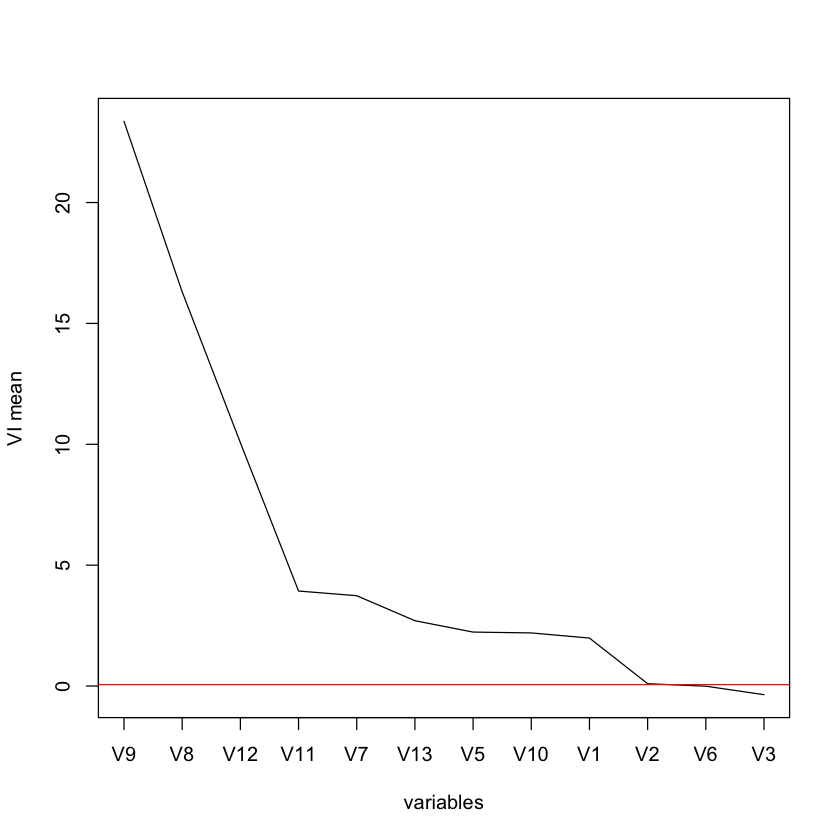

In [88]:
plot(vozone, step = "thres", imp.sd = FALSE, var.names = TRUE)

Trois groupes de variables très sensibles peuvent être discernés, allant du plus important au moins important. Le premier groupe contient les deux températures (8 et 9), la température de base d'inversion (12) connue pour être les meilleurs prédicteurs de l'ozone et le mois (1), qui est un prédicteur important car la concentration d'ozone présente une forte composante saisonnière. Le deuxième groupe de variables météorologiques clairement moins importantes comprend: la hauteur de pression (5), l'humidité (7), la hauteur de la base d'inversion (10), le gradient de pression (11) et la visibilité (13). Enfin, le dernier groupe contient trois variables sans importance: le jour du mois (2), le jour de la semaine (3) bien sûr et, plus surprenant, la vitesse du vent (6). Ce dernier fait est classique: le vent n'entre dans le modèle qu'en cas de pollution par l'ozone, sinon le vent et la pollution sont faiblement corrélés. <br>
Examinons maintenant les résultats des procédures de sélection. Pour refléter l'ordre utilisé dans la définition des variables, nous réorganisons les variables de sortie de la procédure. Avec les paramètres par défaut, l'étape de prédiction ne supprime aucune variable supplémentaire.

In [89]:
number <- c(1:3, 5:13)
number[vozone$varselect.thres]

[1]  9  8 12 11  7 13  5 10  1  2

Après la première étape d'élimination, les 2 variables d'importance négative (variables 6 et 3) sont éliminées, comme prévu.

In [90]:
number[vozone$varselect.interp]

[1]  9  8 12 11  7 13

Ensuite, la procédure d'interprétation conduit à sélectionner le modèle à 6 variables, qui contient toutes les variables les plus importantes.

# <font color='blue'>Les forêts aléatoires </font>

<strong> Definition : </strong><br>
Les forêts aléatoires sont des méthodes qui permettent d’obtenir des modèles prédictifs pour la classification et la régression. La méthode met en œuvre des arbres de décision binaire, notamment des arbres CART proposés par Breiman et al. (1984). <br>

L’idée générale derrière la méthode est la suivante : au lieu d’essayer d’obtenir une méthode optimisée en une fois, on génère plusieurs prédicteurs avant de mettre en commun leurs différentes prédictions. <br>

- En classification (variable réponse qualitative) : la méthode permet de prédire l’appartenance d’observations (observations, individus) à une classe d’une variable qualitative, sur la base de variables explicatives quantitatives et/ou qualitatives. <br>
- En régression (variable réponse continue) : la méthode permet de prédire la valeur prise par une variable quantitative dépendante, en fonction de variables explicatives quantitatives et/ou qualitatives. <br>

# 1. Charger la librairie randomForest

Doc R complet : https://cran.r-project.org/web/packages/randomForest/randomForest.pdf

In [140]:
library(randomForest)
## ----data---------------------------------------------------------------

library(kernlab)

data(spam)
?spam

dim(spam)

spam[1:5, 1:5]

set.seed(9146301)
ytable <- table(spam$type)
app <- c(sample(1:ytable[2], ytable[2]/2), sample((ytable[2] + 1):nrow(spam),
ytable[1]/2))
spam.app <- spam[app, ]
table(spam.app$type)

n <- nrow(spam.app)
p <- ncol(spam.app) - 1
spam.test <- spam[-app, ]
table(spam.test$type)

[1] 4601   58

make,address,all,num3d,our
0.00,0.64,0.64,0,0.32
0.21,0.28,0.50,0,0.14
0.06,0.00,0.71,0,1.23
0.00,0.00,0.00,0,0.63
0.00,0.00,0.00,0,0.63



nonspam    spam 
   1394     906 


nonspam    spam 
   1394     907 

Nous chargeons les données spam depuis kernlab, découpons les données en 50% apprentissage et 50% test. Nous affichons ensuite les tables de contigences relatives aux 2 sous-ensembles. <br>

# 2. Construction d'une RF pour mtry=p (bagging non élagué) et calcul du gain en termes d’erreur par rapport à un arbre seul


In [141]:
## ----bag-----------------------------------------------------------------

bag <- randomForest(type ~ ., data = spam.app, mtry = p)
bag
## ----bag_err-------------------------------------------------------------

predbag <- predict(bag, spam.test)
errbag <- round(sum(predbag != spam.test$type)/nrow(spam.test), 3)
errbag


Call:
 randomForest(formula = type ~ ., data = spam.app, mtry = p) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 57

        OOB estimate of  error rate: 7.22%
Confusion matrix:
        nonspam spam class.error
nonspam    1329   65  0.04662841
spam        101  805  0.11147903

[1] 0.067

Bagging :L’idée ici est qu’en construisant des arbres CART à partir de différents échantillons bootstrap, on en modifie les prédictions, et on construit ainsi une collection variée de prédicteurs. L’étape d’agrégation permet alors d’obtenir un prédicteur robuste et plus performant. <br>

Le Bagging est réputé stabiliser l’arbre CART classique en réduisant fortement sa va- riance et en améliorer sensiblement les performances.

Pour que le bagging soit efficace, il faut :
1. Que les arbres soient individuellement performants
2. De grande profondeur (biais faible) – Taille min. des feuilles = 1
3. Et surtout, très fortement différents les uns des autres pour qu’elles
puissent se compléter. <br>
<br>

Pour cela, on va Introduire une perturbation « aléatoire » dans la construction des arbres, en jouant sur le mécanisme de sélection de variable de segmentation sur les nœuds.

Bootstrap : consiste à créer des « nouveaux échantillons » statistiques, mais uniquement par tirage avec remise, à partir de l'échantillon initial.

Erreur OOB : (out-of-bag error estimation) : mesure l’erreur directement durant l’apprentissage, sans avoir à passer par un échantillon test ou par une technique de type validation croisée. l'OOB utilise le fait que les arbres sont construits sur des estimateurs baggés et que, par conséquent, ils n’utilisent pas toutes les observations de l’échantillon d’apprentissage. Les données prédites sont des données qui n’ont pas été rencontrées au préalable par le prédicteur utilisé. L'erreur OOB estime l’erreur de généralisation d’une forêt, mais elle n’utilise jamais les prédictions de la forêt elle-même, mais plutôt celles de prédicteurs qui sont des agrégations d’arbres de cette forêt

La fonction print nous permet d'afficher quelques caractéristiques de l'objet produit. On apprend ainsi que la forêt est composée de 500 arbres, qu'à chaque noeud l'algorithme fait un essai sur 57 variables, que le taux d'erreur OOB est de 7.22%. La matrice de confusion est également affichée.

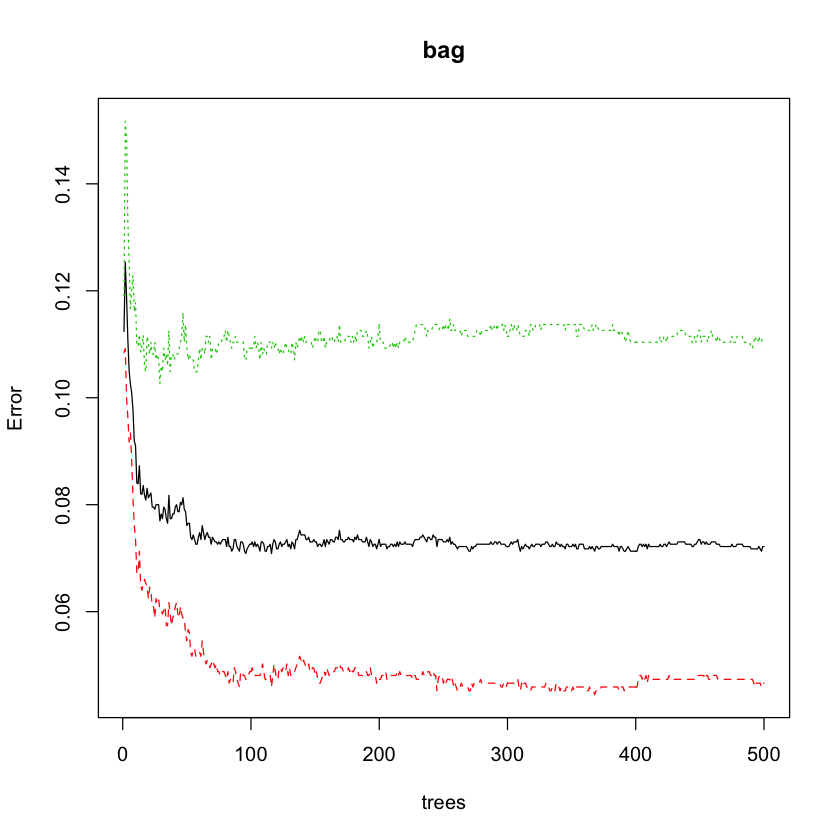

In [68]:
plot(bag)

On peut visualiser ci-dessus l'évolution des erreurs (en fonction du nombre d'arbres). 

In [142]:
tail(bag$err.rate)

,OOB,nonspam,spam
"[495,]",0.07173913,0.04662841,0.1103753
"[496,]",0.07217391,0.04662841,0.1114790
"[497,]",0.07173913,0.04662841,0.1103753
"[498,]",0.07130435,0.04591105,0.1103753
"[499,]",0.07217391,0.04662841,0.1114790
"[500,]",0.07217391,0.04662841,0.1114790


# 3. Construction d'une RF par défaut

In [143]:
## ----rf------------------------------------------------------------------

rf <- randomForest(type ~ ., spam.app)
rf
errrf


Call:
 randomForest(formula = type ~ ., data = spam.app) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 5.52%
Confusion matrix:
        nonspam spam class.error
nonspam    1345   49  0.03515065
spam         78  828  0.08609272

[1] 0.047

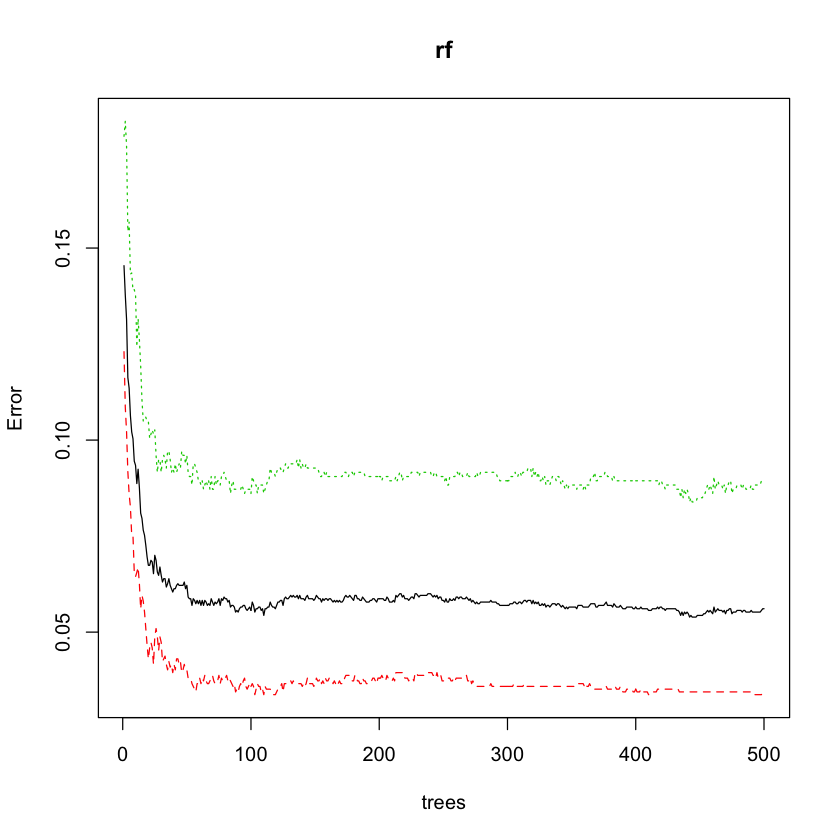

In [92]:
plot(rf)

# 4. Calcul de l'erreur et comparaison avec le bagging

In [144]:
## ----rf_err--------------------------------------------------------------

predrf <- predict(rf, spam.test)
errrf <- round(sum(predrf != spam.test$type)/nrow(spam.test), 3)
errrf

[1] 0.047

On obtient un taux d'erreur de généralisation plus faible ainsi qu'un taux d'OOB plus faible sur le modèle de forêt aléatoire par défaut. La collection d’arbres construite avec les forêts aléatoires est plus diversifiée que celle construite avec le Bagging (du fait des choix aléatoires de variables à chaque nœud). Cette diversité est bénéfique au moment de l’agrégation,ce qui explique la diminution du taux d'OBB. Par ailleurs à chaque noeud, l'algorithme fait un essai sur seulement 7 variables au lieu de 57. <br>

# 5. Etude de l'évolution de l'erreur OOB en fonction de ntree en utilisant do.trace

In [156]:
rf1


Call:
 randomForest(formula = type ~ ., data = spam.app, ntree = 1000,      do.trace = 100) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 7

        OOB estimate of  error rate: 5.43%
Confusion matrix:
        nonspam spam class.error
nonspam    1347   47  0.03371593
spam         78  828  0.08609272

In [157]:
rfpsur3


Call:
 randomForest(formula = type ~ ., data = spam.app, mtry = p/3,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 19

        OOB estimate of  error rate: 6%
Confusion matrix:
        nonspam spam class.error
nonspam    1339   55  0.03945481
spam         83  823  0.09161148

In [158]:
rfp


Call:
 randomForest(formula = type ~ ., data = spam.app, mtry = p, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 57

        OOB estimate of  error rate: 7.13%
Confusion matrix:
        nonspam spam class.error
nonspam    1328   66  0.04734577
spam         98  808  0.10816777

On constate que plus mtry augmente plus l'erreur OOB augmente.

ntree      OOB      1      2
  100:   5.96%  3.73%  9.38%
  200:   5.70%  3.52%  9.05%
  300:   5.39%  3.44%  8.39%
  400:   5.43%  3.52%  8.39%
  500:   5.57%  3.37%  8.94%
  600:   5.57%  3.37%  8.94%
  700:   5.70%  3.37%  9.27%
  800:   5.65%  3.37%  9.16%
  900:   5.74%  3.37%  9.38%
 1000:   5.70%  3.37%  9.27%


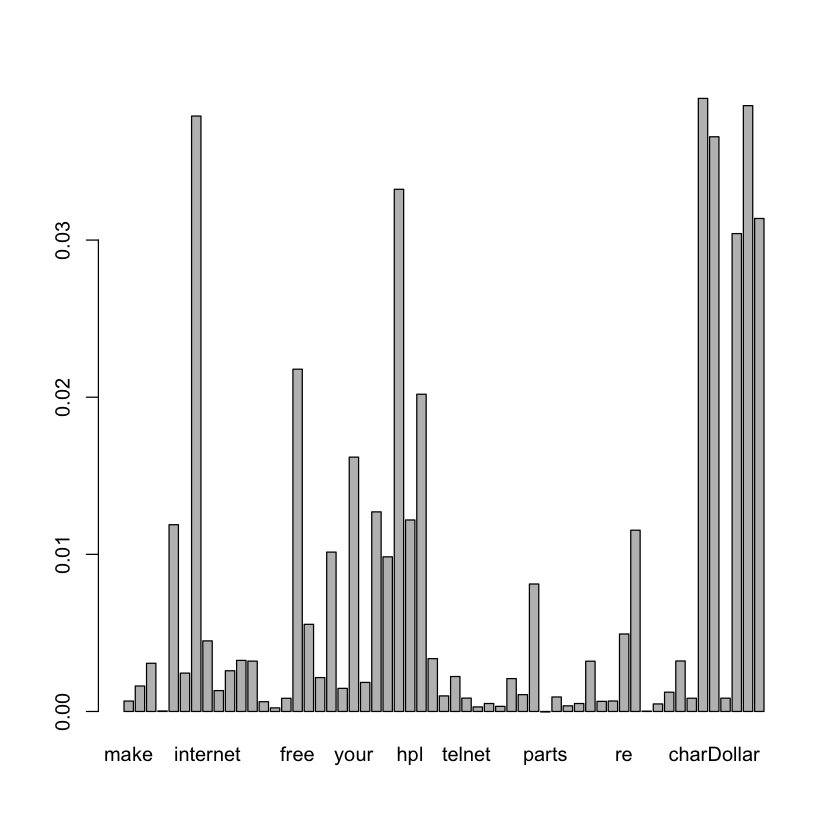

In [145]:
## ----iv------------------------------------------------------------------

rf <- randomForest(type ~ ., data = spam.app, ntree = 1000, do.trace = 100)

rf <- randomForest(type ~ ., data = spam.app, importance = TRUE)
nlev <- nlevels(spam.app$type)
rfimp <- rf$importance[, nlev + 1]
barplot(rfimp)

# <font color='blue'>L'importance des variables </font>

In [95]:
#rf$importance

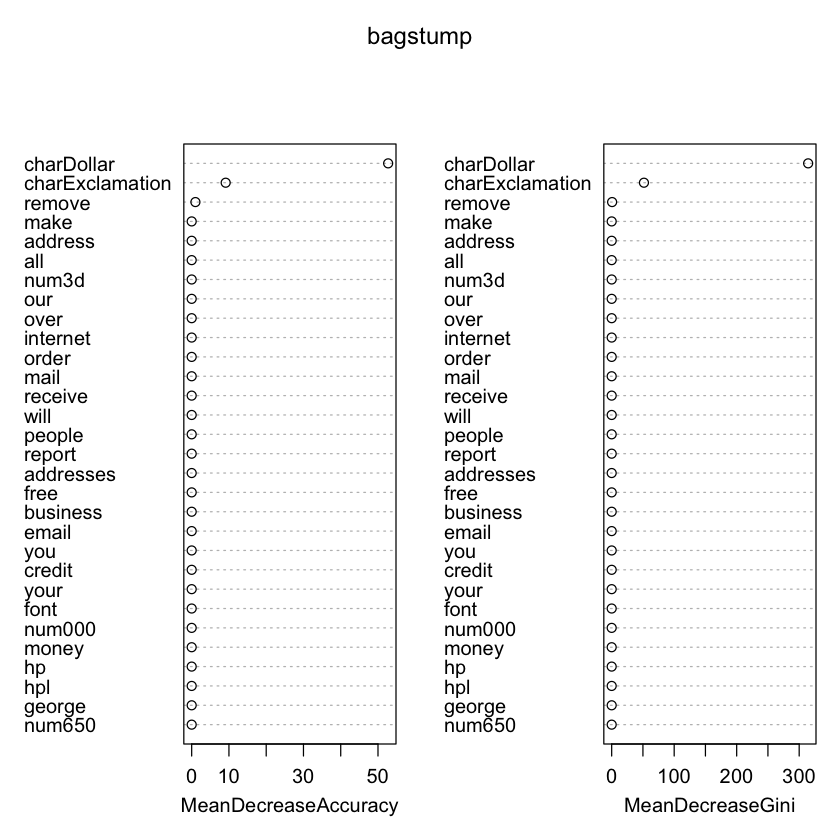

In [124]:
varImpPlot(bagstump)

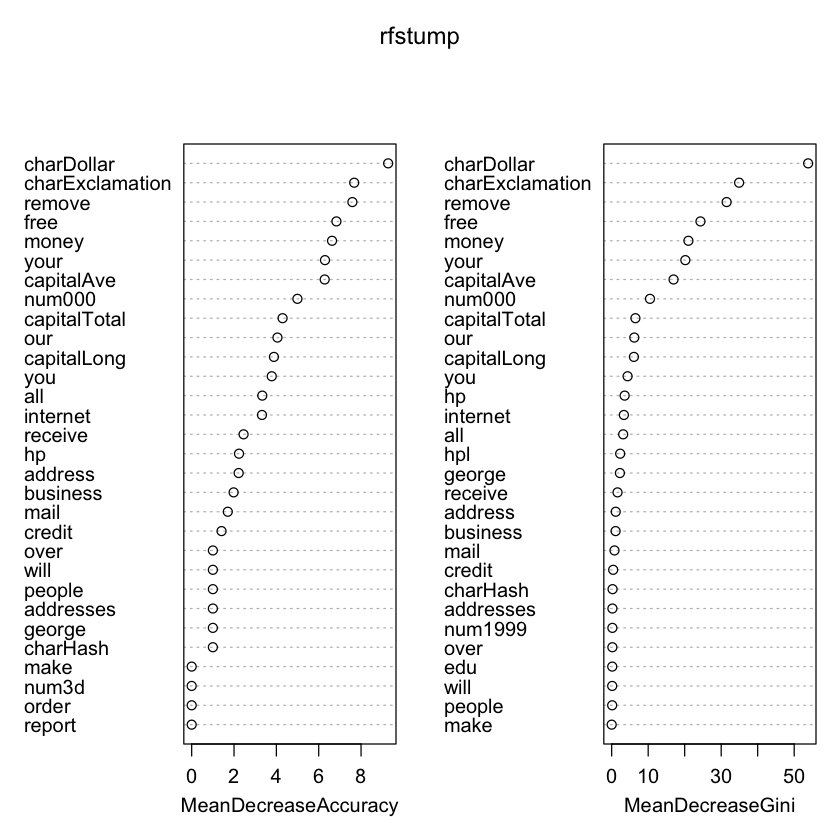

In [126]:
varImpPlot(rfstump)

# 5. Calcul de l'importance des variables  de spam pour la RF par défaut

[1] "charExclamation" "capitalLong"     "remove"          "charDollar"     
[5] "hp"              "capitalTotal"    "capitalAve"      "free"

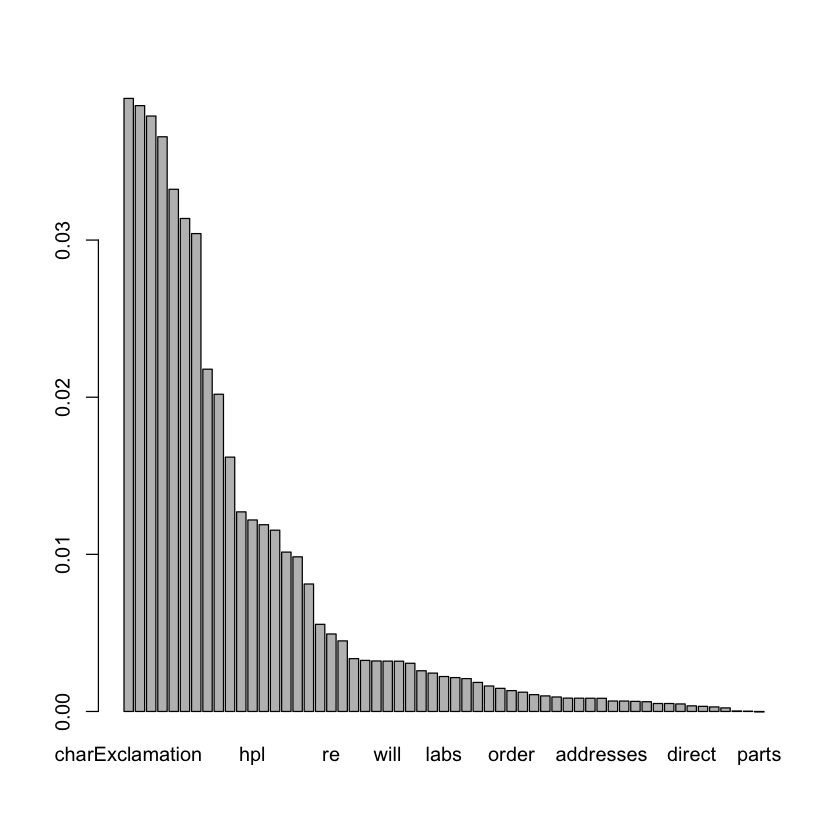

[1] 0.21

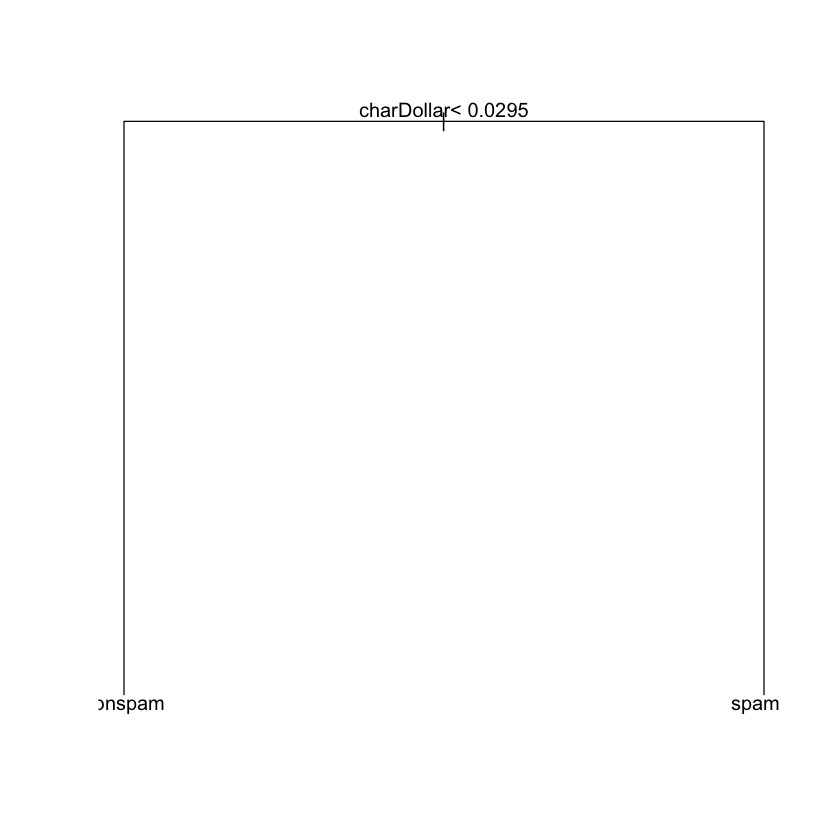

[1] "charDollar"      "charExclamation" "remove"          "make"           
[5] "address"         "all"             "num3d"           "our"

[1] 0.203

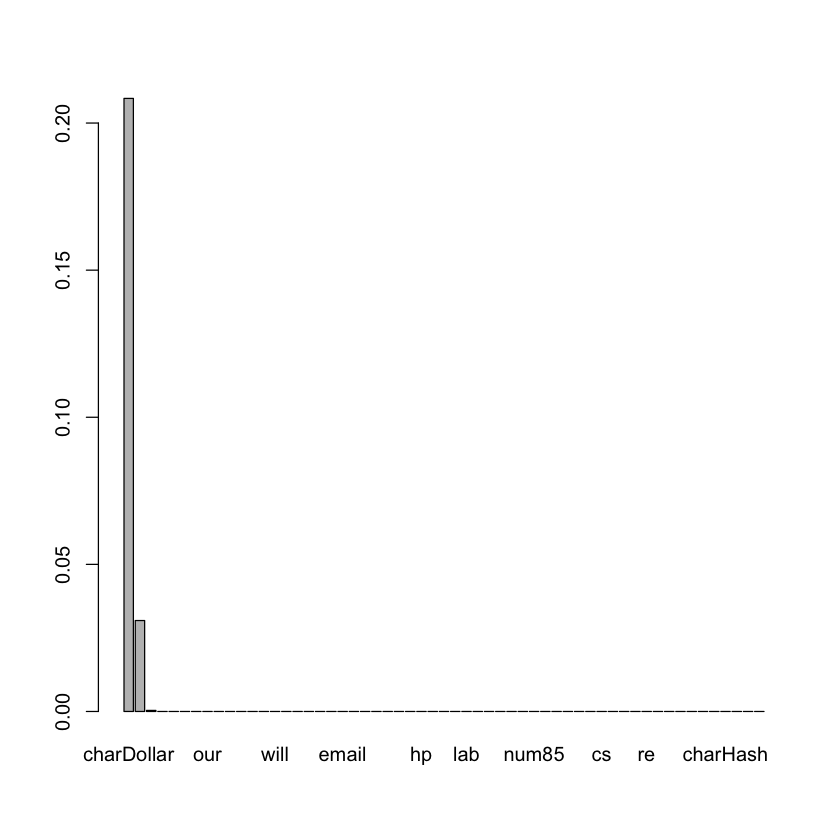

[1] "charDollar"      "charExclamation" "free"            "remove"         
[5] "your"            "capitalLong"     "money"           "capitalAve"

[1] 0.165

[1] 0.08652174

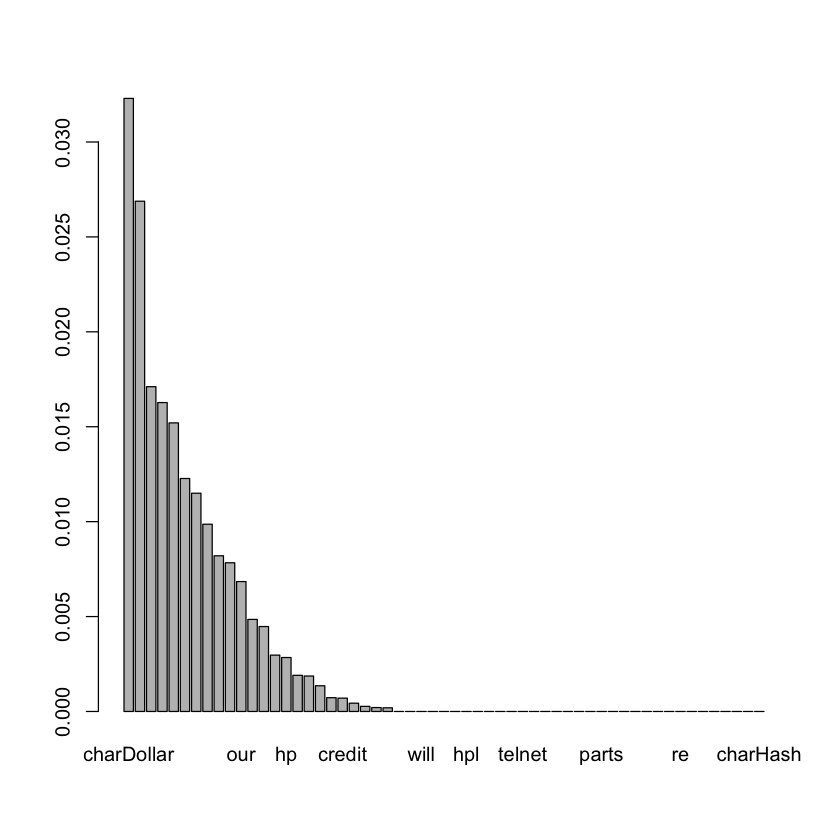

[1] "charExclamation" "charDollar"      "capitalTotal"    "remove"         
[5] "capitalLong"     "capitalAve"      "free"            "your"

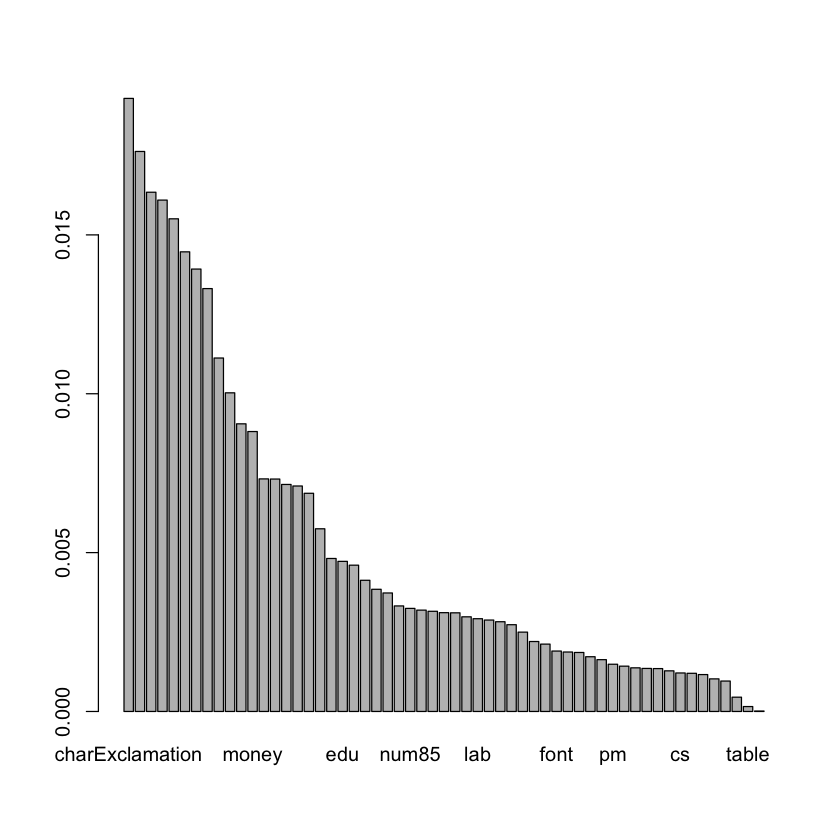

[1] "charExclamation" "capitalLong"     "remove"          "charDollar"     
[5] "hp"              "capitalTotal"    "capitalAve"      "free"

[1] 0.05782609

[1] 0.06130435

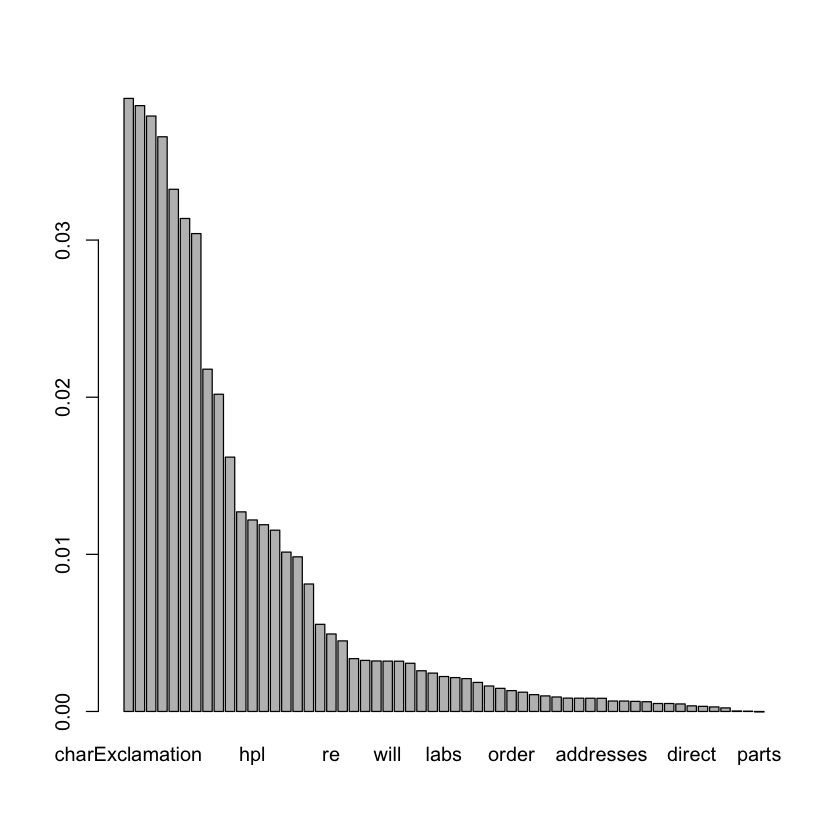

[1] "remove"          "charDollar"      "charExclamation" "hp"             
[5] "capitalLong"     "capitalTotal"    "capitalAve"      "george"

[1] 0.0726087

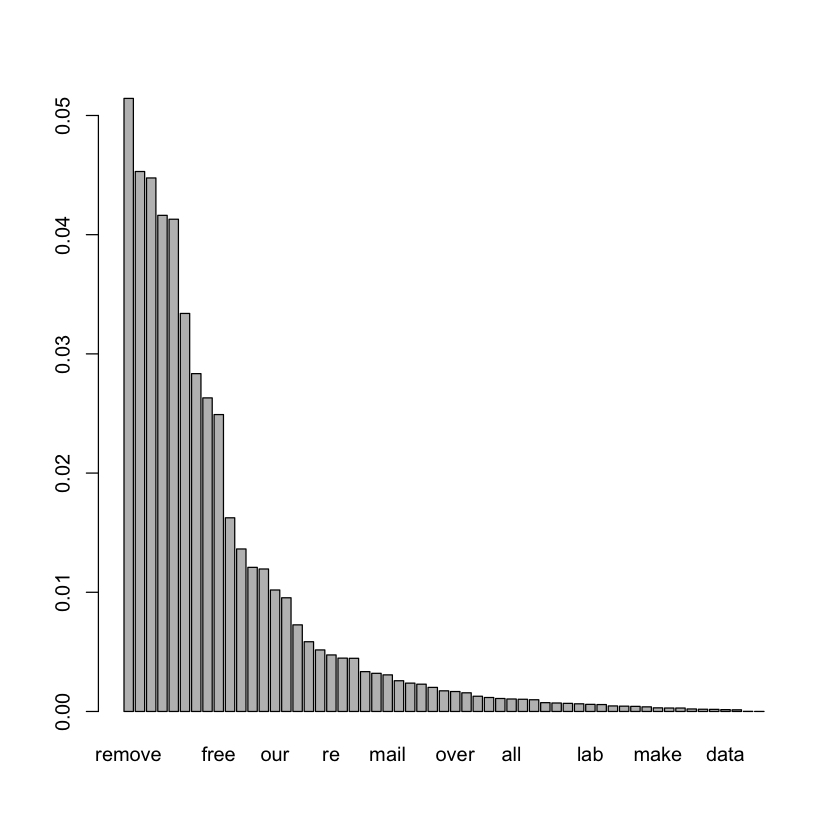

[1] "remove"          "capitalLong"     "hp"              "charDollar"     
[5] "charExclamation" "george"          "capitalTotal"    "edu"

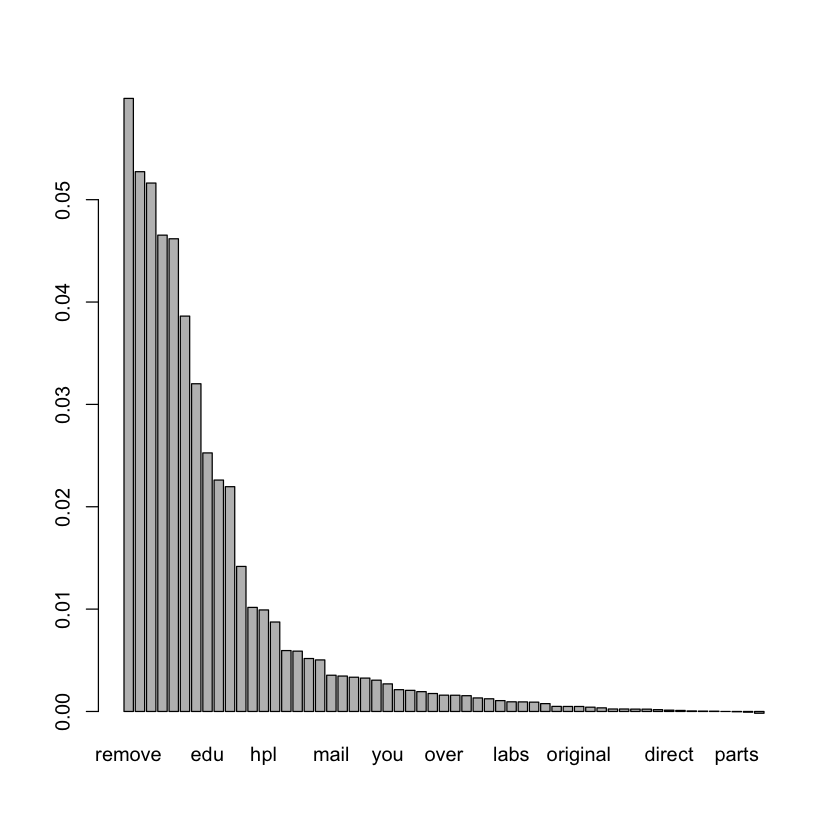

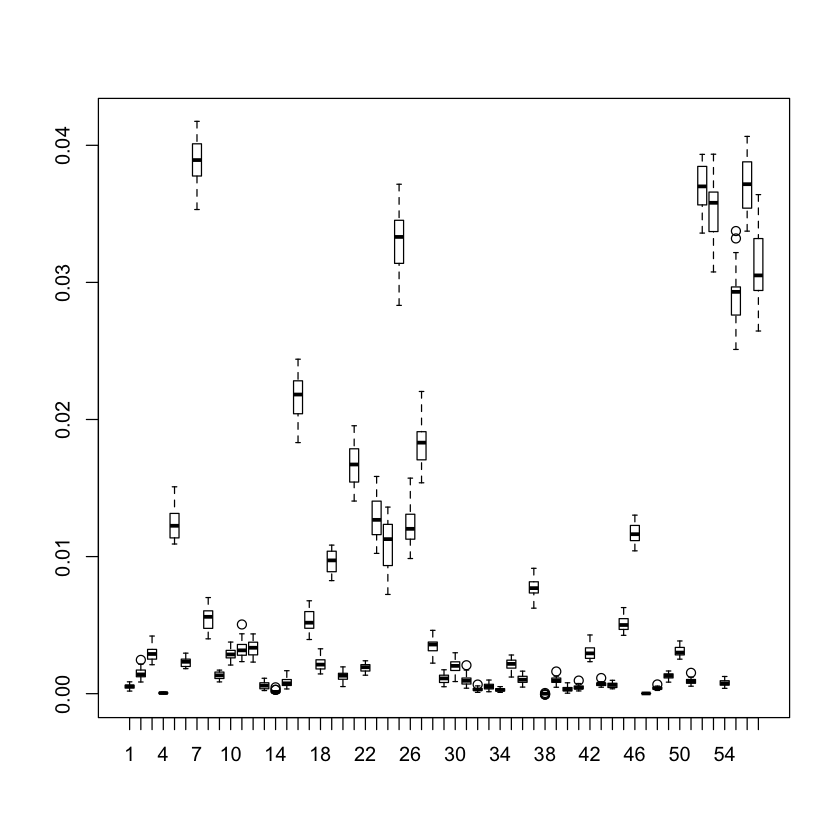

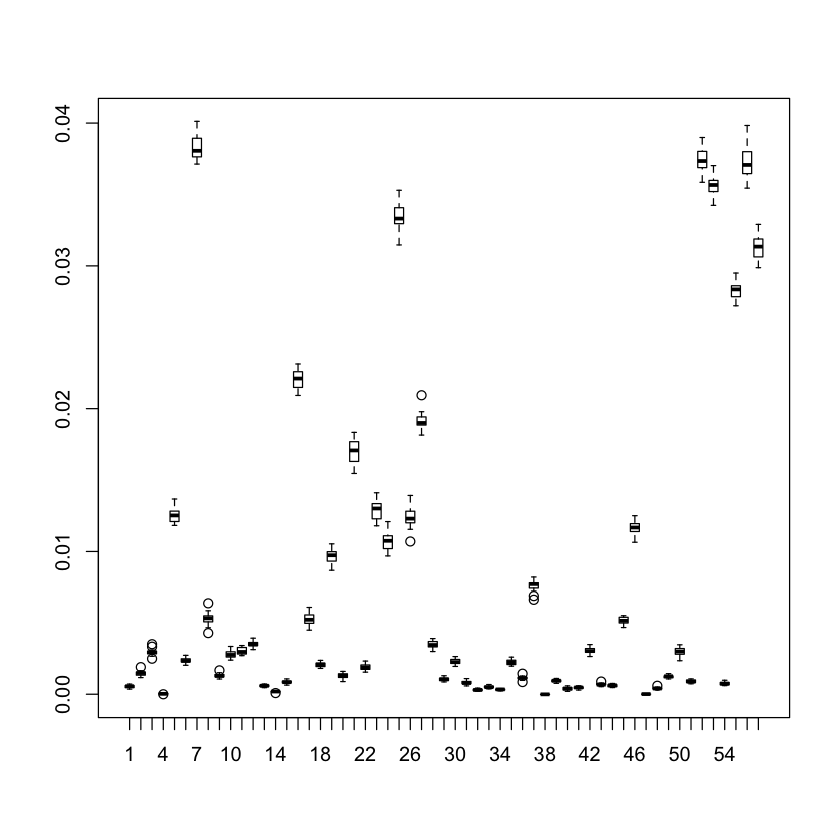

In [73]:
## ----sort_iv-----------------------------------------------------------

rfimpsort <- sort(rfimp, decreasing = TRUE, index.return = TRUE)
barplot(rfimpsort$x)

colnames(spam.app[rfimpsort$ix[1:8]])

plot(tstump)
text(tstump)

errstump

bagstump <- randomForest(type~., spam.app, maxnodes=2, mtry=p, importance=TRUE) #foret stump avec bagging non élagué
bagstumpimpsort <- sort(bagstump$importance[, nlev+1], decreasing=TRUE,
index.return=TRUE)
barplot(bagstumpimpsort$x)

colnames(spam.app[bagstumpimpsort$ix[1:8]])

predbagstump <- predict(bagstump, spam.test)
errbagstump <- round(sum(predbagstump!=spam.test$type)/nrow(spam.test), 3)
errbagstump

rfstump <- randomForest(type~., spam.app, maxnodes=2, importance=TRUE)
rfstumpimpsort <- sort(rfstump$importance[, nlev+1], decreasing=TRUE,
index.return=TRUE)
barplot(rfstumpimpsort$x)

colnames(spam.app[rfstumpimpsort$ix[1:8]])

predrfstump <- predict(rfstump, spam.test)
errrfstump <- round(sum(predrfstump!=spam.test$type)/nrow(spam.test), 3)
errrfstump

#Influence mtry

rf1 <- randomForest(type~., spam.app, mtry=1, importance=TRUE) #mtry =1 (rf1)
tail(rf1$err.rate[, 1], 1)

rf1impsort <- sort(rf1$importance[, nlev+1], decreasing=TRUE, index.return=TRUE)
barplot(rf1impsort$x)

colnames(spam.app[rf1impsort$ix[1:8]])

barplot(rfimpsort$x)

colnames(spam.app[rfimpsort$ix[1:8]])

tail(rf$err.rate[, 1], 1)

rfpsur3 <- randomForest(type~., spam.app, mtry=p/3, importance=TRUE) #mtry =p/3 (rfpsur3)
tail(rfpsur3$err.rate[, 1], 1)

rfpsur3impsort <- sort(rfpsur3$importance[, nlev+1], decreasing=TRUE,
index.return=TRUE)
barplot(rfpsur3impsort$x)

colnames(spam.app[rfpsur3impsort$ix[1:8]])

rfp <- randomForest(type~., spam.app, mtry=p, importance=TRUE) #mtry = p (rfp)
tail(rfp$err.rate[,1], 1)

rfpimpsort <- sort(rfp$importance[,nlev+1], decreasing=TRUE, index.return=TRUE)
barplot(rfpimpsort$x)

colnames(spam.app[rfpimpsort$ix[1:8]])

vimultntree100 <- matrix(NA, nrow = 20, ncol = p)
for (i in 1:20) {
rf <- randomForest(type ~ ., spam.app, ntree = 100, importance = TRUE)
vimultntree100[i, ] <- rf$importance[, nlev + 1]
}
boxplot(vimultntree100)

vimult <- matrix(NA, nrow = 20, ncol = p)
for (i in 1:20) {
rf <- randomForest(type ~ ., spam.app, importance = TRUE)
vimult[i, ] <- rf$importance[, nlev + 1]
}
boxplot(vimult)



In [133]:
sort(round(importance(rf), 2)[,1])

parts            num857             table        conference 
            -2.03             -1.40             -0.63              0.35 
           num415          original              data                pm 
             1.99              2.11              2.12              2.22 
            num3d            report              make            telnet 
             2.35              2.41              2.48              2.49 
              lab            people           project                cs 
             2.66              2.83              3.44              3.58 
              all              will            direct             num85 
             3.76              4.50              4.75              5.30 
             labs  charRoundbracket           address             order 
             5.63              5.82              6.01              6.18 
           num650         addresses charSquarebracket        technology 
             7.04              7.09              7.10              7.63 
         charHash     charSemicolon            credit             email 
             7.84              8.13              8.64              8.92 
             mail              over           meeting               you 
             9.04              9.70             10.98             11.29 
               re           receive              font               hpl 
            11.35             11.45             11.71             12.11 
         business              your          internet           num1999 
            12.90             13.87             14.71             15.13 
            money            num000               our            george 
            15.64             17.22             17.49             17.73 
              edu       capitalLong        capitalAve                hp 
            20.34             21.73             22.44             22.61 
     capitalTotal              free   charExclamation        charDollar 
            23.45             28.54             31.24             31.66 
           remove 
            35.10

In [134]:
sort(round(importance(rfstump), 2)[,1])

make             num3d             order            report 
             0.00              0.00              0.00              0.00 
            email              font               hpl            num650 
             0.00              0.00              0.00              0.00 
              lab              labs            telnet            num857 
             0.00              0.00              0.00              0.00 
             data            num415             num85        technology 
             0.00              0.00              0.00              0.00 
          num1999             parts                pm            direct 
             0.00              0.00              0.00              0.00 
               cs           meeting          original           project 
             0.00              0.00              0.00              0.00 
               re               edu             table        conference 
             0.00              0.00              0.00              0.00 
    charSemicolon  charRoundbracket charSquarebracket              over 
             0.00              0.00              0.00              1.00 
             will            people         addresses            george 
             1.00              1.00              1.00              1.00 
         charHash            credit              mail          business 
             1.00              1.41              1.71              1.98 
          address                hp           receive          internet 
             2.22              2.24              2.46              3.32 
              all               you       capitalLong               our 
             3.33              3.78              3.88              4.05 
     capitalTotal            num000        capitalAve              your 
             4.29              4.99              6.28              6.29 
            money              free            remove   charExclamation 
             6.63              6.83              7.59              7.67 
       charDollar 
             9.27

Les forêts aléatoires permettent de classer les variables explicatives par ordre d’importance dans la prévision, sans gros prétraitement au préalable sur ces données. <br>

Dans les boxplot ci-dessus, on peut observer que tous les prédicteurs n'ont pas le même ordre de grandeur

Tout d’abord, on construit la forêt aléatoire, on calcule l’erreur OOB “out-of-bag” de la forêt. <br>

Le score d’une variable explicative Xi est calculé comme suit: <br>

- on permute aléatoirement les valeurs de la variable explicative parmi les observations de l’ensemble d’entrainement
- on calcule à nouveau l’erreur out-of-bag et on fait la différence avec OOB.
- on renormalise les scores.

L'une des forces de random Forest est de permettre ce classement de variables, aussi bien sur un petit jeu de données que sur un grand jeu de données. Les premiers graphiques ci-dessus montrent le classement des variables par ordre décroissant d’importance sur les données spam. En se restreignant aux huit plus importantes qui semblent se dégager, on trouve les proportions d’occurrences des mots ou caractères remove, hp, $,!, free ainsi que les 3 variables liées aux longueurs des suites de lettres majuscules. <br>
Les variables impliquées dans les premières découpes de l’arbre optimal (voir la Figure 3) ne sont pas en tête du classement par importance des variables, même si elles apparaissent bien classées. Au contraire, certaines variables peuvent être importantes et ne pas apparaître dans l’arbre en question, tel est le cas ici de la variable la plus importante : capitalLong.

# VSURF

Documentation complète : https://hal.inria.fr/hal-01096233/document

L’algorithme de VSURF est construit à partir de deux étapes :
1. Une élimination préliminaire des variables à partir d’un classement est effectuée. Cette étape consiste à trier les variables par ordre décroissant de VIM et d’éliminer les variables avec une faible importance. Le seuil de rejet est obtenu à partir de l’écart type des VIM. <br>
<br>
2. La sélection des variables se divise en deux sous-étapes, la première concerne l’interprétation et la seconde concerne la prédiction. <br>
<br>
a. Interprétation <br>
Cette étape consiste à entraîner plusieurs forêts aléatoires en augmentant progressivement le nombre de variables sélectionnées à l’étape 1. L’ordre de l’ajout des variables est défini par le rang des VIM utilisées à l’étape 1. La
23
première variable ajoutée est donc la plus importante. Les variables sélection- nées sont celles contenues dans le modèle qui mènent à la plus petite erreur OOB. <br>
<br>
b. Prédiction <br>
Les variables utilisées dans cette étape sont celles sélectionnées à l’étape d’interprétation. Une séquence de forêts aléatoires est construite, toutes les va- riables sont testées à l’aide d’une procédure pas à pas ("stepwise"). Les va- riables du dernier modèle sont ensuite sélectionnées.

In [80]:
install.packages("VSURF")

also installing the dependencies ‘RcppEigen’, ‘doParallel’, ‘Rborist’, ‘ranger’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Procédure de sélection des variables en trois étapes basée sur des forêts aléatoires. Initialement développé pour gérer des données de grande dimension (pour lesquelles le nombre de variables dépasse largement le nombre d'observations), le package est très polyvalent et peut traiter la plupart des dimensions des données, pour les problèmes de régression et de classification supervisée. La première étape est consacrée à éliminer les variables non pertinentes de l'ensemble de données. La deuxième étape vise à sélectionner toutes les variables liées à la réponse à des fins d'interprétation. La troisième étape affine la sélection en éliminant la redondance dans l'ensemble de variables sélectionnées par la deuxième étape, à des fins de prédiction

In [81]:
## ----vsurf_load----------------------------------------------------------

library(VSURF)


In [82]:
## ----vsurf_spam----------------------------------------------------------

small.n <- 500
ytable.app <- table(spam.app$type)
small.app <- c(sample(1:ytable.app[2], ytable.app[2]/n * small.n),
sample((ytable.app[2] + 1):n, ytable.app[1]/n * small.n))
spam.small.app <- spam.app[small.app, ]
table(spam.small.app$type)



nonspam    spam 
    303     196 

Thresholding step
Estimated computational time (on one core): 2612.4 sec.

Interpretation step (on 55 variables)
Estimated computational time (on one core): between 361.6 sec. and  5952.4 sec.

Prediction step (on 23 variables)
Maximum estimated computational time (on one core): 1178.8 sec.
  |======================================================================| 100%

Warning message in VSURF.formula(type ~ ., spam.app, parallel = TRUE, ncores = 3):
“VSURF with a formula-type call outputs selected variables
which are indices of the input matrix based on the formula:
you may reorder these to get indices of the original data”

[1] "remove"          "charExclamation" "charDollar"      "hp"             
 [5] "capitalLong"     "capitalTotal"    "capitalAve"      "george"         
 [9] "free"            "edu"             "your"            "num000"         
[13] "hpl"             "our"             "money"           "num1999"        
[17] "you"             "business"        "font"            "re"             
[21] "num650"          "internet"        "meeting"

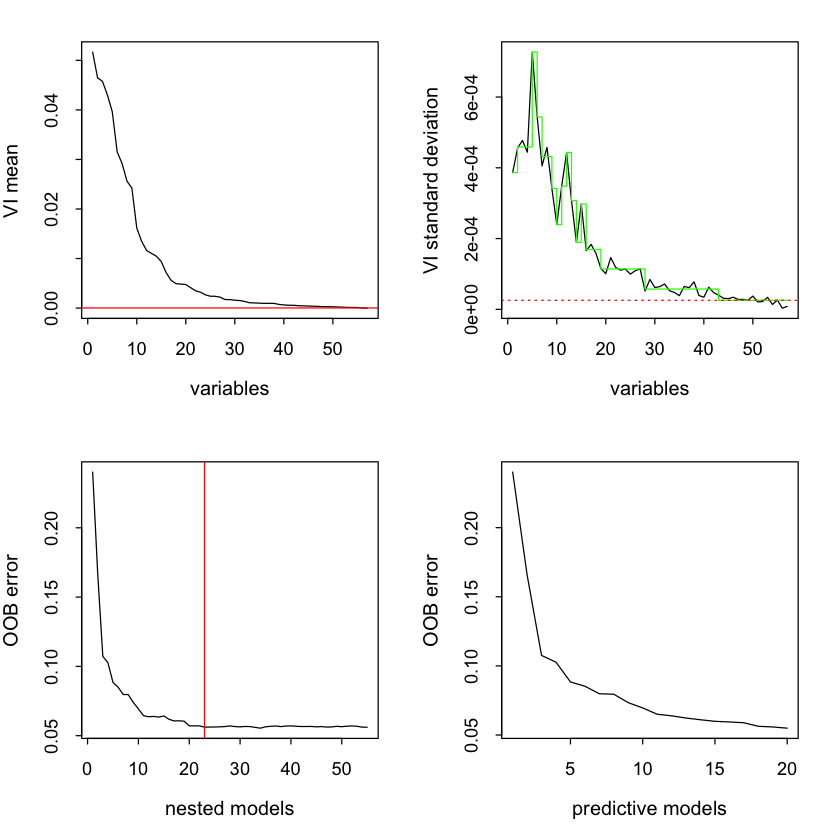

In [84]:
## ----vsurf_spam_run-----------------------------------------------------
# BE AWARE THAT THE FOLLOWING COMMAND TAKES AROUND 1 HOUR TO RUN
# ON A COMPUTER, WITH PARALLEL COMPUTING USING 3 CORES

vsurf.spam <- VSURF(type~., spam.app, parallel = TRUE, ncores = 3)

plot(vsurf.spam, cex.axis = 1.1, cex.lab = 1.2)
colnames(spam.app[vsurf.spam$varselect.interp])


Le package VSURF offre une procédure de sélection des variables en trois étapes basée sur des forêts aléatoires. Initialement développé pour gérer des données de grande dimension (pour lesquelles le nombre de variables dépasse largement le nombre d'observations), le package est très polyvalent et peut traiter la plupart des dimensions des données, pour les problèmes de régression et de classification supervisée. 
- La première étape est consacrée à éliminer les variables non pertinentes de l'ensemble de données. 
- La deuxième étape vise à sélectionner toutes les variables liées à la réponse à des fins d'interprétation. 
- La troisième étape affine la sélection en éliminant la redondance dans l'ensemble de variables sélectionnées par la deuxième étape, à des fins de prédiction.

Les graphiques du haut résument l’étape de seuillage, celui d’en bas à gauche illustre l’obtention de l’ensemble d’interprétation et en bas à droite, de prédiction. <br>
Partant de 57 variables, la première étape d'élimination (voir les deux graphiques du haut de la Figure) les conserve quasiment toutes, l’étape d’interprétation (voir le graphique en bas à gauche) sélectionne environ la moitié (29) des variables et pour la prédiction (voir le graphique en bas à droite) une quinzaine.


 VSURF computation time: 1 hours 

 VSURF selected: 
	55 variables at thresholding step (in 22.6 mins)
	23 variables at interpretation step (in 27.9 mins)
	20 variables at prediction step (in 10.8 mins)

 VSURF ran in parallel on a PSOCK cluster and used 3 cores 


[1] "remove"          "charExclamation" "charDollar"      "hp"             
 [5] "capitalLong"     "capitalTotal"    "capitalAve"      "george"         
 [9] "free"            "edu"             "your"            "num000"         
[13] "hpl"             "our"             "money"           "num1999"        
[17] "you"             "business"        "font"            "re"             
[21] "num650"          "internet"        "meeting"

[1] "remove"          "charExclamation" "charDollar"      "hp"             
 [5] "capitalLong"     "capitalTotal"    "capitalAve"      "george"         
 [9] "free"            "edu"             "your"            "num000"         
[13] "our"             "num1999"         "you"             "business"       
[17] "font"            "re"              "num650"          "meeting"

Thresholding step
Estimated computational time (on one core): 48 sec.
  |======================================================================| 100%
Interpretation step (on 26 variables)
Estimated computational time (on one core): between 15 sec. and  68.3 sec.
  |======================================================================| 100%
Prediction step (on 6 variables)
Maximum estimated computational time (on one core): 6.2 sec.
  |======================================================================| 100%

Warning message in VSURF.formula(type ~ ., spam.small.app, maxnodes = 2):
“VSURF with a formula-type call outputs selected variables
which are indices of the input matrix based on the formula:
you may reorder these to get indices of the original data”


 VSURF computation time: 1.6 mins 

 VSURF selected: 
	26 variables at thresholding step (in 48.1 secs)
	6 variables at interpretation step (in 41.7 secs)
	3 variables at prediction step (in 4.8 secs)


[1] "charDollar"      "charExclamation" "free"            "your"           
[5] "remove"          "capitalLong"

[1] "charDollar"      "charExclamation" "free"

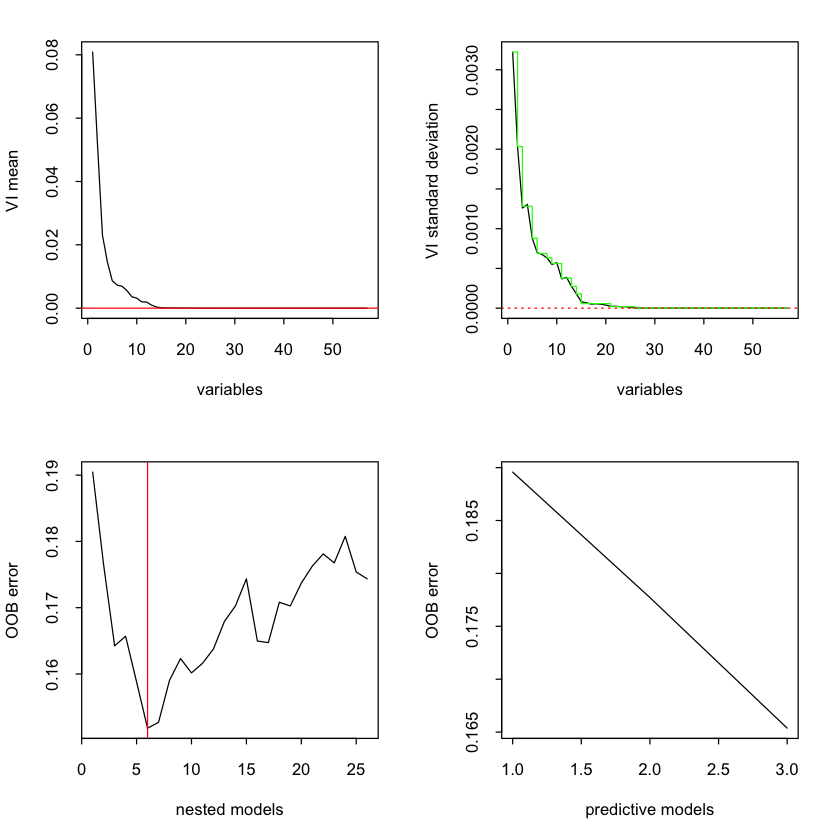

In [85]:
## ------------------------------------------------------------------------

summary(vsurf.spam)

colnames(spam.app[vsurf.spam$varselect.interp])
colnames(spam.app[vsurf.spam$varselect.pred])

vsurf.stump <- VSURF(type ~ ., spam.small.app, maxnodes = 2)

summary(vsurf.stump)

plot(vsurf.stump)

colnames(spam.app[vsurf.stump$varselect.interp])

colnames(spam.app[vsurf.stump$varselect.pred])



# CONCLUSION

# Arbres de décision : avantages et inconvénients 

Avantages : <br>
• facilité d'interprétation <br>
• sélection automatique des variables pertinentes <br>
• non paramétrique <br>
• traitement indifférencié selon le type des variables prédictives <br>
• robuste face aux données aberrantes, solutions pour les données manquantes <br> 
• robuste face aux variables redondantes <br>
• rapidité et capacité à traiter des très grandes bases <br>
• enrichir l’interprétation des règles à l’aide des variables non sélectionnées <br>
• possibilité pour le praticien d’intervenir dans la construction de l’arbre <br>
<br>
Inconvénients : <br>
<br>
• problème de stabilité sur les petites bases de données (feuilles à très petits effectifs) <br>
• recherche « pas-à-pas » : difficulté à trouver certaines interactions (ex. xor) <br>
• peu adapté au « scoring » <br>
• performances moins bonnes en général par rapport aux autres méthodes (en réalité, performances fortement dépendantes de la taille de la base d’apprentissage)

# Forêts aléatoires : avantages et inconvénients 

Avantages : <br>
• Bonnes performances en prédiction <br>
• Paramétrage simple (B et m) <br>
• Pas de problème d’overfitting (on peut augmenter B) <br>
• Mesure de l’importance des variables <br>
• Evaluation de l’erreur intégrée (OOB) <br>
• Possibilité de programmation parallèle <br>
• Souvent utilisées comme benchmark dans les compétition de machine learning

Incovénients : <br>
• boite noire : difficilement interprétable, difficilement améliorable<br>
• entrainement assez lent <br>